# Research Fellow - B02 08882 - Technical Test  -  Dr Narinder Kaur

# Tasks 1-4 are carried out through this notebook 

### Introduction
### 1. Explore data source Synthea and carry out data understanding 
### 2. Load Conditions, Encounters, Medications, Observations and Patients
### 3. Data Preprocessing for each file 
### 4. Carry out data linkage when neccessary
### 5. Exploratory analysis

In [25]:
import pandas as pd
import numpy as np

## Section 1: Conditions



In [26]:
# Task 1 Load conditions csv 
conditions_url = r"C:\Users\narin\Desktop\UCL_EMRs_Analysis\conditions.csv"
conditions = pd.read_csv(conditions_url)

In [27]:
conditions.head(5)

,START,STOP,PATIENT,ENCOUNTER,CODE
0,24/06/2013,02/07/2013,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,0b2794bd-ec2b-d34f-0610-2523b3b7fcf0,10509002.0
1,27/02/2016,14/03/2016,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,a6d818dd-0983-fd1c-eefa-3d2295532c45,283371005.0
2,11/08/2016,22/08/2016,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,36d2e781-4655-0a11-1f70-c69856e02019,444814009.0
3,27/11/2016,17/12/2016,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,c8eaaf41-958b-31ab-7de5-568cee8751f3,444814009.0
4,22/02/2017,02/06/2017,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,6474f606-5a1b-48c0-bbbf-ad6dcbc24d4e,16114001.0


In [28]:
conditions.shape

(38100, 5)

In [29]:
#Checking for missingness 
print(conditions.isnull().sum())

START           0
STOP         8169
PATIENT         0
ENCOUNTER       0
CODE           48
dtype: int64


In [30]:
# Captures missingness 
conditions['CODE'] = conditions['CODE'].fillna('Unknown')

In [31]:
# Load SNOMED Dictionary 
# Check if dictionary codes are consistent with Conditions.csv 

snomed_dict_path = r"C:\Users\narin\Desktop\UCL_EMRs_Analysis\dictionary_snomed.csv"
snomed_df = pd.read_csv(snomed_dict_path)

snomed_df.head(5)

,CODE,DESCRIPTION
0,10509002.0,Acute bronchitis (disorder)
1,283371005.0,Laceration of forearm
2,444814009.0,Viral sinusitis (disorder)
3,16114001.0,Fracture of ankle
4,44465007.0,Sprain of ankle


In [32]:
print(snomed_df.isnull().sum())

CODE           0
DESCRIPTION    0
dtype: int64


In [33]:
snomed_df.dtypes

CODE           float64
DESCRIPTION     object
dtype: object

In [34]:
conditions.dtypes

START        object
STOP         object
PATIENT      object
ENCOUNTER    object
CODE         object
dtype: object

### 1.1 Merge with SNOMED Dictionary

In [35]:
# Check for duplicates in the dictionary
dupes = snomed_df[snomed_df.duplicated(subset='CODE', keep=False)]
print("Duplicates in SNOMED dictionary:")
print(dupes)

Duplicates in SNOMED dictionary:
            CODE           DESCRIPTION
70   233604007.0  Pneumonia (disorder)
82    84757009.0              Epilepsy
157   84757009.0   Epilepsy (disorder)
176  233604007.0             Pneumonia


In [36]:
# Ensure both CODE columns are numeric (Int64 handles missing)
conditions['CODE'] = pd.to_numeric(conditions['CODE'], errors='coerce').astype('Int64')
snomed_df['CODE'] = pd.to_numeric(snomed_df['CODE'], errors='coerce').astype('Int64')

# Merge on the CODE column 
merged_conditions = conditions.merge(
    snomed_df[['CODE', 'DESCRIPTION']],
    left_on='CODE',
    right_on='CODE',
    how='left'
)

In [37]:
merged_conditions.head()

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,24/06/2013,02/07/2013,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,0b2794bd-ec2b-d34f-0610-2523b3b7fcf0,10509002,Acute bronchitis (disorder)
1,27/02/2016,14/03/2016,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,a6d818dd-0983-fd1c-eefa-3d2295532c45,283371005,Laceration of forearm
2,11/08/2016,22/08/2016,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,36d2e781-4655-0a11-1f70-c69856e02019,444814009,Viral sinusitis (disorder)
3,27/11/2016,17/12/2016,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,c8eaaf41-958b-31ab-7de5-568cee8751f3,444814009,Viral sinusitis (disorder)
4,22/02/2017,02/06/2017,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,6474f606-5a1b-48c0-bbbf-ad6dcbc24d4e,16114001,Fracture of ankle


In [38]:
merged_conditions.shape

(38170, 6)

In [39]:
print(merged_conditions.isnull().sum())

START             0
STOP           8221
PATIENT           0
ENCOUNTER         0
CODE             48
DESCRIPTION     138
dtype: int64


In [40]:
# See the latest date in conditions data
merged_conditions['START'].max()

'31/12/2020'

In [41]:
conditions['START']= pd.to_datetime(conditions['START'], errors='coerce')

min_date = conditions['START'].min()
max_date = conditions['START'].max()

print(f"Date range of diagnoses: {min_date.date()} to {max_date.date()}")


Date range of diagnoses: 1919-06-06 to 2021-12-11


## Conditions dataset cleaned

In [42]:
merged_conditions.to_csv('conditions_with_snomed_clean.csv', index=False)

In [43]:
top_10_conditions = (
    merged_conditions.groupby(['CODE', 'DESCRIPTION'])
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='Count')
)
print(top_10_conditions)

        CODE                                 DESCRIPTION  Count
0  160903007              Full-time employment (finding)  13793
1   73595000                            Stress (finding)   5131
2  160904001              Part-time employment (finding)   2422
3  422650009                  Social isolation (finding)   1240
4  444814009                  Viral sinusitis (disorder)   1235
5  423315002            Limited social contact (finding)   1197
6  741062008                Not in labor force (finding)   1076
7  706893006  Victim of intimate partner abuse (finding)    818
8  195662009          Acute viral pharyngitis (disorder)    678
9   10509002                 Acute bronchitis (disorder)    571


In [44]:
# SNOWMED codes include social factors too

# Section 2: Paitents

In [47]:
# Task 1 Load conditions csv 
patients_url = r"C:\Users\narin\Desktop\UCL_EMRs_Analysis\patients.csv"
patients = pd.read_csv(patients_url)

In [48]:
patients.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,2019-02-17,NaN,999-65-3251,NaN,NaN,NaN,Damon455,Langosh790,NaN,...,Middleborough Massachusetts US,620 Lynch Tunnel Apt 0,Springfield,Massachusetts,Hampden County,1104.0,42.080389,-72.480431,9039.1645,7964.1255
1,339144f8-50e1-633e-a013-f361391c4cff,1998-05-11,NaN,999-10-8743,S99996708,X75063318X,Mr.,Chi716,Greenfelder433,NaN,...,Athens Athens Prefecture GR,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375
2,d488232e-bf14-4bed-08c0-a82f34b6a197,2003-01-28,1999-01-01,999-56-6057,S99929424,NaN,Ms.,Phillis443,Walter473,NaN,...,Boston Massachusetts US,677 Ritchie Terrace,Hingham,Massachusetts,Plymouth County,2043.0,42.200491,-70.916076,582557.8030,104782.2070
3,217f95a3-4e10-bd5d-fb67-0cfb5e8ba075,1993-12-23,NaN,999-91-4320,S99991143,X44132498X,Mr.,Jerrold404,Herzog843,NaN,...,Boston Massachusetts US,276 Bernier Branch,Revere,Massachusetts,Suffolk County,NaN,42.381875,-70.999286,475826.8550,18067.0950
4,faac724a-a9e9-be66-fe1e-3044dc0ba8ea,2020-12-04,NaN,999-31-8261,NaN,NaN,NaN,Brandon214,Watsica258,NaN,...,Northborough Massachusetts US,734 Brakus Pathway Unit 28,New Marlborough,Massachusetts,Berkshire County,NaN,42.147028,-73.217103,31468.0400,206.2200


In [49]:
patients.shape

(1162, 25)

In [50]:
print(patients.isnull().sum())

Id                        0
BIRTHDATE                 2
DEATHDATE               998
SSN                       0
DRIVERS                 215
PASSPORT                275
PREFIX                  244
FIRST                     0
LAST                      0
SUFFIX                 1146
MAIDEN                  831
MARITAL                 383
RACE                      0
ETHNICITY                 0
GENDER                   20
BIRTHPLACE                0
ADDRESS                   0
CITY                      0
STATE                     0
COUNTY                    0
ZIP                     544
LAT                       0
LON                       0
HEALTHCARE_EXPENSES       0
HEALTHCARE_COVERAGE       0
dtype: int64


# 2.1 Working with dates to calculate age

In [51]:
# Convert BIRTHDATE column to datetime for further transformation

patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'], errors='coerce')
patients['DEATHDATE'] = pd.to_datetime(patients['DEATHDATE'], errors='coerce')


In [52]:
# Some Max dates are 2034 which are implausible entries

In [53]:
patients['BIRTHDATE'].max()

Timestamp('2034-01-01 00:00:00')

In [54]:
# Remove patients born after 2025 (removes anomolies)
patients = patients[patients['BIRTHDATE'] <= pd.Timestamp('2025-01-01')]
patients.shape
# 19 patients had implausible entries

(1143, 25)

In [55]:
patients['BIRTHDATE'].max()

Timestamp('2021-09-24 00:00:00')

### It is known that the End time point of the SYNTHEA dataset is 2021-09-24 as this is the max entered in the dataset. Therefore this will be used for the age calculation. 

In [56]:
# Set a reference date (end of synthetic data timeline)
reference_date = pd.Timestamp("2021-09-24")

# Calculate age (use DEATHDATE if present, otherwise reference_date)
patients["AGE"] = ((patients["DEATHDATE"].fillna(reference_date) - patients["BIRTHDATE"]).dt.days // 365)

In [57]:
patients['DEATHDATE'].value_counts()

1999-01-01    1
1983-12-27    1
2001-08-24    1
2021-06-18    1
2010-01-04    1
             ..
2012-08-05    1
2017-02-18    1
1998-01-09    1
1991-06-18    1
1997-09-05    1
Name: DEATHDATE, Length: 158, dtype: int64

In [58]:
patients['AGE'].describe()

count    1143.000000
mean       41.868766
std        25.452100
min        -5.000000
25%        20.000000
50%        42.000000
75%        60.000000
max       121.000000
Name: AGE, dtype: float64

### In many EMR quality control pipelines (e.g. CPRD, OMOP, Synthea validations), age > 120 is the common rule to flag likely errors.

### Age > 120 is more likely a data bug (e.g. wrong birth year) than a real value.



In [59]:
# Remove implausible ages
patients = patients[(patients["AGE"] >= 0) & (patients["AGE"] <= 120)]

In [60]:
patients['AGE'].describe()

count    1138.000000
mean       41.631810
std        25.032797
min         0.000000
25%        20.000000
50%        41.500000
75%        60.000000
max       110.000000
Name: AGE, dtype: float64

In [61]:
patients.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
0,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,2019-02-17,NaT,999-65-3251,NaN,NaN,NaN,Damon455,Langosh790,NaN,...,620 Lynch Tunnel Apt 0,Springfield,Massachusetts,Hampden County,1104.0,42.080389,-72.480431,9039.1645,7964.1255,2
1,339144f8-50e1-633e-a013-f361391c4cff,1998-05-11,NaT,999-10-8743,S99996708,X75063318X,Mr.,Chi716,Greenfelder433,NaN,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
3,217f95a3-4e10-bd5d-fb67-0cfb5e8ba075,1993-12-23,NaT,999-91-4320,S99991143,X44132498X,Mr.,Jerrold404,Herzog843,NaN,...,276 Bernier Branch,Revere,Massachusetts,Suffolk County,NaN,42.381875,-70.999286,475826.8550,18067.0950,27
4,faac724a-a9e9-be66-fe1e-3044dc0ba8ea,2020-12-04,NaT,999-31-8261,NaN,NaN,NaN,Brandon214,Watsica258,NaN,...,734 Brakus Pathway Unit 28,New Marlborough,Massachusetts,Berkshire County,NaN,42.147028,-73.217103,31468.0400,206.2200,0
5,23d16ee3-8cd4-eeb8-e77e-1e5fbf4c4159,1990-12-15,NaT,999-60-9905,S99950633,X36202735X,Mr.,Rodrigo242,Arellano2,NaN,...,538 Crona Underpass,Revere,Massachusetts,Suffolk County,2151.0,42.443262,-71.022322,772362.7250,2213.0850,30


In [62]:
patients['AGE'].value_counts()

61     23
54     22
27     21
47     20
51     20
       ..
105     1
85      1
103     1
98      1
104     1
Name: AGE, Length: 108, dtype: int64

In [65]:
patients.head(1)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
0,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,2019-02-17,NaT,999-65-3251,NaN,NaN,NaN,Damon455,Langosh790,NaN,...,620 Lynch Tunnel Apt 0,Springfield,Massachusetts,Hampden County,1104.0,42.080389,-72.480431,9039.1645,7964.1255,2


In [66]:
# replace NaT and Nan with unknown. 

patients.fillna("Unknown", inplace=True)

In [67]:
patients['DEATHDATE'].value_counts()

Unknown                981
1983-12-27 00:00:00      1
2001-08-24 00:00:00      1
2021-06-18 00:00:00      1
2010-01-04 00:00:00      1
                      ... 
2012-08-05 00:00:00      1
2017-02-18 00:00:00      1
1998-01-09 00:00:00      1
1991-06-18 00:00:00      1
1997-09-05 00:00:00      1
Name: DEATHDATE, Length: 158, dtype: int64

In [68]:
patients.shape

(1138, 26)

In [69]:
num_unique_ids = patients['Id'].nunique()
print(num_unique_ids)

1138


## Transforming Gender

In [70]:
patients['GENDER'].value_counts()

F          584
M          530
Unknown     20
8293.3       4
Name: GENDER, dtype: int64

In [71]:
# Replace 8293.3 and any other unexpected value with 'Unknown'
patients['GENDER'] = patients['GENDER'].apply(lambda x: x if x in ['M', 'F'] else 'Unknown')

In [72]:
patients['GENDER'].value_counts()

F          584
M          530
Unknown     24
Name: GENDER, dtype: int64

In [77]:
print(patients.isnull().sum())

Id                     0
BIRTHDATE              0
DEATHDATE              0
SSN                    0
DRIVERS                0
PASSPORT               0
PREFIX                 0
FIRST                  0
LAST                   0
SUFFIX                 0
MAIDEN                 0
MARITAL                0
RACE                   0
ETHNICITY              0
GENDER                 0
BIRTHPLACE             0
ADDRESS                0
CITY                   0
STATE                  0
COUNTY                 0
ZIP                    0
LAT                    0
LON                    0
HEALTHCARE_EXPENSES    0
HEALTHCARE_COVERAGE    0
AGE                    0
dtype: int64


In [79]:

#patients['ETHNICITY'].value_counts()

## Patient dataset Cleaned

In [81]:
patients.to_csv('patients_clean.csv', index=False)

# 2.2 Merge with Conditions and further data preprocessing

In [119]:
print(patients.columns.tolist())

['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'AGE']


In [120]:
print(merged_conditions.columns.tolist())

['START', 'STOP', 'Id', 'ENCOUNTER', 'CODE', 'DESCRIPTION']


In [121]:
merged_conditions = merged_conditions.rename(columns={'PATIENT': 'Id'})

In [122]:
merged = pd.merge(merged_conditions, patients, on='Id', how='right')

In [123]:
merged.shape

(37563, 31)

In [124]:
unique_patient_count = merged['Id'].nunique()
print(f"Number of unique patient IDs: {unique_patient_count}")


Number of unique patient IDs: 1138


In [125]:
merged.head(50)

,START,STOP,Id,ENCOUNTER,CODE,DESCRIPTION,BIRTHDATE,DEATHDATE,SSN,DRIVERS,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
0,NaN,NaN,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,<NA>,NaN,2019-02-17,Unknown,999-65-3251,Unknown,...,620 Lynch Tunnel Apt 0,Springfield,Massachusetts,Hampden County,1104.0,42.080389,-72.480431,9039.1645,7964.1255,2
1,11/06/2012,17/06/2013,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,160968000,Risk activity involvement (finding),1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
2,07/08/2012,02/09/2012,339144f8-50e1-633e-a013-f361391c4cff,4224e87e-d63e-4b30-a01b-03daffac9d26,44465007,Sprain of ankle,1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
3,29/06/2015,NaN,339144f8-50e1-633e-a013-f361391c4cff,28f73bd9-73d3-de33-35a6-cabeb9a5795c,162864005,Body mass index 30+ - obesity (finding),1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
4,04/07/2016,NaN,339144f8-50e1-633e-a013-f361391c4cff,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
5,04/07/2016,NaN,339144f8-50e1-633e-a013-f361391c4cff,8195411f-4a65-9245-07d3-1999e1c223df,105531004,Housing unsatisfactory (finding),1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
6,04/07/2016,NaN,339144f8-50e1-633e-a013-f361391c4cff,8195411f-4a65-9245-07d3-1999e1c223df,5251000000000,Received certificate of high school equivalenc...,1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
7,04/07/2016,10/07/2017,339144f8-50e1-633e-a013-f361391c4cff,8195411f-4a65-9245-07d3-1999e1c223df,160903007,Full-time employment (finding),1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
8,19/06/2017,01/07/2017,339144f8-50e1-633e-a013-f361391c4cff,ea367dd3-2edd-6b98-343f-8be24eb69561,195662009,Acute viral pharyngitis (disorder),1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23
9,10/07/2017,16/07/2018,339144f8-50e1-633e-a013-f361391c4cff,2e7d1cee-3edb-a847-fb23-271c30727dd6,160904001,Part-time employment (finding),1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375,23


In [126]:
merge_clean = merged.dropna(subset=['ENCOUNTER'])
merge_clean.shape

(37547, 31)

In [127]:
#check for duplicates
merge_clean = merge_clean.drop_duplicates(subset=['Id', 'CODE', 'START', 'STOP'])
merge_clean.shape

(37457, 31)

In [128]:
print(merge_clean.isnull().sum())

START                     0
STOP                   8019
Id                        0
ENCOUNTER                 0
CODE                     27
DESCRIPTION             110
BIRTHDATE                 0
DEATHDATE                 0
SSN                       0
DRIVERS                   0
PASSPORT                  0
PREFIX                    0
FIRST                     0
LAST                      0
SUFFIX                    0
MAIDEN                    0
MARITAL                   0
RACE                      0
ETHNICITY                 0
GENDER                    0
BIRTHPLACE                0
ADDRESS                   0
CITY                      0
STATE                     0
COUNTY                    0
ZIP                       0
LAT                       0
LON                       0
HEALTHCARE_EXPENSES       0
HEALTHCARE_COVERAGE       0
AGE                       0
dtype: int64


## Those with missing codes have a missing description and are patient duplicates.There are also two patients who have a death date before birth date. 

In [129]:
missing_code_rows = merge_clean[merge_clean['CODE'].isna()]
missing_code_rows.head(10)

,START,STOP,Id,ENCOUNTER,CODE,DESCRIPTION,BIRTHDATE,DEATHDATE,SSN,DRIVERS,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
1622,14/02/1984,19/02/1985,87daa935-0fc8-61cf-9e00-b8540c292903,db6df485-fec1-bbd4-3f6b-74ea3337cbe7,<NA>,NaN,1959-11-17,Unknown,999-51-1827,S99983576,...,727 O'Kon Green Suite 87,Methuen,Massachusetts,Essex County,1844.0,42.723989,-71.161411,1.387814e+06,1236.5475,61
3238,27/02/1995,NaN,fee55adf-498c-5111-2136-e805906a3a74,2049f60b-25a6-aad0-ae83-ee27dedd6f1c,<NA>,NaN,1974-12-23,Unknown,999-77-4082,S99944844,...,313 Smitham Underpass,Haverhill,Massachusetts,Essex County,1830.0,42.785193,-71.085710,2.342041e+06,279507.1580,46
3239,27/02/1995,22/03/1999,fee55adf-498c-5111-2136-e805906a3a74,2049f60b-25a6-aad0-ae83-ee27dedd6f1c,<NA>,NaN,1974-12-23,Unknown,999-77-4082,S99944844,...,313 Smitham Underpass,Haverhill,Massachusetts,Essex County,1830.0,42.785193,-71.085710,2.342041e+06,279507.1580,46
3565,20/01/2021,NaN,7378ba81-94b8-baa9-93d0-bf7d25af0048,0a0cc066-db5e-0d95-4d16-f5f0510b3d1f,<NA>,NaN,1976-06-30,Unknown,999-32-4040,S99929350,...,321 Marquardt Parade,Lancaster,Massachusetts,Worcester County,Unknown,42.521785,-71.713072,1.153357e+06,3548.4150,45
3621,23/03/2019,14/07/2019,9b94051f-59a9-c941-61af-9acf2a9af22f,410960a6-9024-fd1c-3e19-48a149b95864,<NA>,NaN,1945-07-17,Unknown,999-61-4586,S99940951,...,307 Kulas Approach Unit 81,Rehoboth,Massachusetts,Bristol County,Unknown,41.862397,-71.209293,1.792753e+06,109927.3215,76
5747,25/11/2018,27/10/2019,c8ff4993-f646-91ea-f261-c8622dd1500a,574b55c0-011b-834f-86c0-f2b58d66b0c2,<NA>,NaN,1978-11-19,Unknown,999-88-3087,S99997226,...,771 Jerde Viaduct,Brookline,Massachusetts,Norfolk County,2215.0,42.278426,-71.163390,1.593131e+06,297654.1540,42
5748,25/11/2018,29/11/2020,c8ff4993-f646-91ea-f261-c8622dd1500a,574b55c0-011b-834f-86c0-f2b58d66b0c2,<NA>,NaN,1978-11-19,Unknown,999-88-3087,S99997226,...,771 Jerde Viaduct,Brookline,Massachusetts,Norfolk County,2215.0,42.278426,-71.163390,1.593131e+06,297654.1540,42
5749,25/11/2018,NaN,c8ff4993-f646-91ea-f261-c8622dd1500a,574b55c0-011b-834f-86c0-f2b58d66b0c2,<NA>,NaN,1978-11-19,Unknown,999-88-3087,S99997226,...,771 Jerde Viaduct,Brookline,Massachusetts,Norfolk County,2215.0,42.278426,-71.163390,1.593131e+06,297654.1540,42
6981,22/10/1963,16/06/1964,ef167059-cef0-12c4-49db-993ca3a20c01,fa108ef8-45eb-7fe3-ce25-15df43c06a6f,<NA>,NaN,1928-11-13,2008-11-15 00:00:00,999-78-2852,S99972880,...,160 Halvorson Ranch,Burlington,Massachusetts,Middlesex County,1803.0,42.490679,-71.260833,2.956473e+06,359839.5145,80
8773,18/03/1975,NaN,c893e2b1-4238-52b6-e8e1-1ed709e42ce3,6969fc91-8c89-362a-0a81-15bea3ba0b31,<NA>,NaN,1940-12-31,1993-05-15 00:00:00,999-26-6883,S99954934,...,355 Langworth Manor,Northborough,Massachusetts,Worcester County,1532.0,42.289448,-71.624193,1.339839e+06,13424.9100,52


In [130]:
# Drop rows where CODE is missing
merge_clean = merge_clean.dropna(subset=['CODE'])

In [131]:
merge_clean.shape

(37430, 31)

In [132]:
missing_code_rows = merge_clean[merge_clean['STOP'].isna()]
missing_code_rows.head(2)

,START,STOP,Id,ENCOUNTER,CODE,DESCRIPTION,BIRTHDATE,DEATHDATE,SSN,DRIVERS,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
3,29/06/2015,NaN,339144f8-50e1-633e-a013-f361391c4cff,28f73bd9-73d3-de33-35a6-cabeb9a5795c,162864005,Body mass index 30+ - obesity (finding),1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.06116,571935.8725,787.5375,23
4,04/07/2016,NaN,339144f8-50e1-633e-a013-f361391c4cff,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,1998-05-11,Unknown,999-10-8743,S99996708,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.06116,571935.8725,787.5375,23


## 2.3 STOP column - some conditions are chronic 

In [133]:
merge_clean['STOP'] = merge_clean['STOP'].fillna('Ongoing')


In [134]:
merge_clean['STOP'] = merge_clean['STOP'].fillna('Ongoing')


# Missingness in merged dataset 
- Add missing SNOMED Codes
- "Invalid for non exisiting codes"

In [135]:
missing_code_rows = merge_clean[merge_clean['DESCRIPTION'].isna()]
missing_code_rows.head(2)

,START,STOP,Id,ENCOUNTER,CODE,DESCRIPTION,BIRTHDATE,DEATHDATE,SSN,DRIVERS,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
322,16/02/2021,26/02/2021,8fa5a097-1970-9370-4193-a7baa3d235b5,b6358095-06f1-cc6a-ac12-3d46550a254a,132281000119108,NaN,2000-08-25,Unknown,999-84-8860,S99941898,...,804 Mohr Lodge Apt 92,Everett,Massachusetts,Middlesex County,2148.0,42.451741,-71.070179,2.146008e+05,115026.0475,21
592,04/12/2013,Ongoing,1cfa5a70-7f3c-4227-5cf1-e182fcff4cd4,5e9526cc-be26-ab6e-7562-79bdc299f9d7,368581000119106,NaN,1958-09-18,Unknown,999-24-1375,S99923833,...,112 Metz Track,Quincy,Massachusetts,Norfolk County,2186.0,42.250009,-70.978059,2.056354e+06,599891.6990,63


In [136]:
missing_code_rows['CODE']

322      132281000119108
592      368581000119106
639      124171000119105
767      368581000119106
1123     124171000119105
              ...       
36671    368581000119106
36878    368581000119106
37050    132281000119108
37154    368581000119106
37279    368581000119106
Name: CODE, Length: 83, dtype: Int64

## 2.4 Carry out mapping for code and descriptions that are missing for: 

- 'Neuropathy due to type 2 diabetes mellitus (disorder)'
- 'Acute deep venous thrombosis'
- 'Chronic intractable migraine without aura'

In [138]:
# Found missing description 

merge_clean.loc[merge_clean['CODE'] == 368581000119106, 'DESCRIPTION'] = 'Neuropathy due to type 2 diabetes mellitus (disorder)'

In [139]:
# Mapping of other codes to correct descriptions
code_mapping = {
    132281000119108: 'Acute deep venous thrombosis',
    124171000119105: 'Chronic intractable migraine without aura'
}

# Update DESCRIPTION for each matching code
for code, desc in code_mapping.items():
    merge_clean.loc[merge_clean['CODE'] == code, 'DESCRIPTION'] = desc

In [140]:
check_rows = merge_clean[merge_clean['CODE'] == 368581000119106]
check_rows.head(5)

,START,STOP,Id,ENCOUNTER,CODE,DESCRIPTION,BIRTHDATE,DEATHDATE,SSN,DRIVERS,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
592,04/12/2013,Ongoing,1cfa5a70-7f3c-4227-5cf1-e182fcff4cd4,5e9526cc-be26-ab6e-7562-79bdc299f9d7,368581000119106,Neuropathy due to type 2 diabetes mellitus (di...,1958-09-18,Unknown,999-24-1375,S99923833,...,112 Metz Track,Quincy,Massachusetts,Norfolk County,2186.0,42.250009,-70.978059,2056353.781,599891.699,63
767,27/01/2017,Ongoing,060e72d3-912e-55cd-0c92-5faa6cb7a6db,2ad929f3-d5b1-86ce-f609-521a335d1d37,368581000119106,Neuropathy due to type 2 diabetes mellitus (di...,1969-01-03,Unknown,999-66-6825,S99931952,...,941 Rodriguez Trace Suite 61,Quincy,Massachusetts,Norfolk County,2169.0,42.240058,-70.987747,181651.842,262994.998,52
2866,16/05/2005,Ongoing,3beee40e-512b-420f-38a3-28e56cddbc9b,6d7efd46-747b-8c8c-3236-f595dc131b47,368581000119106,Neuropathy due to type 2 diabetes mellitus (di...,1952-07-28,Unknown,999-52-7932,S99926912,...,581 Kassulke Trailer Unit 64,Heath,Massachusetts,Franklin County,Unknown,42.676444,-72.818084,2412845.779,36652.171,69
3659,24/09/2012,Ongoing,9ef4db86-c427-ddfe-a607-737f08ffb0c1,d4496d86-c13a-eb7a-7321-24bfd3d3c68e,368581000119106,Neuropathy due to type 2 diabetes mellitus (di...,1973-04-02,Unknown,999-67-3698,S99988330,...,239 Upton Walk,Lowell,Massachusetts,Middlesex County,1852.0,42.644893,-71.284652,2756377.855,392992.925,48
4325,18/10/2019,Ongoing,80534c6c-b12d-caa5-42de-b179fd7f9695,70f47d94-89e6-3fea-fa09-4ba8fe9be77b,368581000119106,Neuropathy due to type 2 diabetes mellitus (di...,1994-08-12,Unknown,999-72-1186,S99951045,...,711 Walter Parade,Barnstable,Massachusetts,Barnstable County,2635.0,41.666469,-70.456633,671635.590,825.780,27


In [141]:
print(merge_clean.isnull().sum())

START                  0
STOP                   0
Id                     0
ENCOUNTER              0
CODE                   0
DESCRIPTION            9
BIRTHDATE              0
DEATHDATE              0
SSN                    0
DRIVERS                0
PASSPORT               0
PREFIX                 0
FIRST                  0
LAST                   0
SUFFIX                 0
MAIDEN                 0
MARITAL                0
RACE                   0
ETHNICITY              0
GENDER                 0
BIRTHPLACE             0
ADDRESS                0
CITY                   0
STATE                  0
COUNTY                 0
ZIP                    0
LAT                    0
LON                    0
HEALTHCARE_EXPENSES    0
HEALTHCARE_COVERAGE    0
AGE                    0
dtype: int64


In [142]:
nan_description_rows = merge_clean[merge_clean['DESCRIPTION'].isna()]
nan_description_rows.head(5)

,START,STOP,Id,ENCOUNTER,CODE,DESCRIPTION,BIRTHDATE,DEATHDATE,SSN,DRIVERS,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
7143,27/02/1996,30/04/1996,ef167059-cef0-12c4-49db-993ca3a20c01,4cf010ef-1b08-42b5-3799-096942b96743,283371000000,NaN,1928-11-13,2008-11-15 00:00:00,999-78-2852,S99972880,...,160 Halvorson Ranch,Burlington,Massachusetts,Middlesex County,1803.0,42.490679,-71.260833,2.956473e+06,359839.5145,80
7144,27/02/1996,25/02/1997,ef167059-cef0-12c4-49db-993ca3a20c01,4cf010ef-1b08-42b5-3799-096942b96743,283371000000,NaN,1928-11-13,2008-11-15 00:00:00,999-78-2852,S99972880,...,160 Halvorson Ranch,Burlington,Massachusetts,Middlesex County,1803.0,42.490679,-71.260833,2.956473e+06,359839.5145,80
7585,25/02/2019,02/03/2020,561db9de-7617-4fed-b230-1553b8dd65f3,54a66cbc-0c1f-8585-a785-94ea368e4ec0,283371000000,NaN,1995-12-04,Unknown,999-50-1190,S99984536,...,719 Frami Rue Suite 69,Palmer,Massachusetts,Hampden County,1079.0,42.164765,-72.367595,6.506867e+05,496988.4905,25
7586,25/02/2019,08/03/2021,561db9de-7617-4fed-b230-1553b8dd65f3,54a66cbc-0c1f-8585-a785-94ea368e4ec0,283371000000,NaN,1995-12-04,Unknown,999-50-1190,S99984536,...,719 Frami Rue Suite 69,Palmer,Massachusetts,Hampden County,1079.0,42.164765,-72.367595,6.506867e+05,496988.4905,25
18633,16/06/2015,02/07/2015,411b4d1d-dd68-1a09-7d8a-7d1f0e7a3d7c,05075753-1c20-385c-6cc2-b9d40ac4bda4,283371000000,NaN,1989-12-19,Unknown,999-36-9442,S99966454,...,328 Hartmann Ferry Suite 1,Methuen,Massachusetts,Essex County,1841.0,42.671367,-71.123520,1.107525e+06,427571.0665,31


## Now it is safe to drop columns with invalid SNOMED codes 

In [143]:
merge_clean = merge_clean.dropna(subset=['DESCRIPTION'])


In [144]:
# Check for added codes. 
unique_descriptions = merge_clean['DESCRIPTION'].unique()
print(unique_descriptions)

['Risk activity involvement (finding)' 'Sprain of ankle'
 'Body mass index 30+ - obesity (finding)' 'Hypertension'
 'Housing unsatisfactory (finding)'
 'Received certificate of high school equivalency (finding)'
 'Full-time employment (finding)' 'Acute viral pharyngitis (disorder)'
 'Part-time employment (finding)' 'Stress (finding)'
 'Not in labor force (finding)' 'Viral sinusitis (disorder)'
 'Limited social contact (finding)' 'Refugee (person)'
 'Social isolation (finding)' 'Received higher education (finding)'
 'Reports of violence in the environment (finding)' 'Sinusitis (disorder)'
 'Chronic sinusitis (disorder)' 'Laceration of thigh' 'Dyspnea (finding)'
 'Wheezing (finding)' 'Suspected COVID-19' 'COVID-19'
 'Acute bronchitis (disorder)'
 'Victim of intimate partner abuse (finding)' 'Seizure disorder'
 'History of single seizure (situation)'
 'Served in armed forces (finding)' 'First degree burn' 'Diabetes'
 'Hypertriglyceridemia (disorder)'
 'Escherichia coli urinary tract infec

### TASK 2) for SNOMED 

## Number of patients with at least one condition

In [145]:
## Number of patients with at least one condition
unique_patients_with_condition = merge_clean['Id'].nunique()
print(f"Number of unique patients with at least one condition: {unique_patients_with_condition}")

Number of unique patients with at least one condition: 1122


# Number of unqiue conditions

In [146]:
### Number of unqiue conditions

unique_conditions = merge_clean['CODE'].nunique()
print(f"Number of unique SNOMED conditions: {unique_conditions}")


Number of unique SNOMED conditions: 202


# Top 10 Clinical diagnoses (e.g. things labeled as "(disorder)")

In [147]:
# Keep only rows where DESCRIPTION contains "(disorder)"
clinical_conditions = merge_clean[merge_clean['DESCRIPTION'].str.contains(r'\(disorder\)', na=False)]

In [148]:
top_10_conditions = (
    clinical_conditions.groupby(['CODE', 'DESCRIPTION'])
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='Count')
)
print(top_10_conditions)

        CODE                           DESCRIPTION  Count
0  444814009            Viral sinusitis (disorder)   1200
1  195662009    Acute viral pharyngitis (disorder)    668
2   10509002           Acute bronchitis (disorder)    553
3  271737000                     Anemia (disorder)    318
4   40055000          Chronic sinusitis (disorder)    217
5   43878008  Streptococcal sore throat (disorder)    159
6   75498004  Acute bacterial sinusitis (disorder)     72
7  302870006       Hypertriglyceridemia (disorder)     70
8  237602007       Metabolic syndrome X (disorder)     67
9   64859006               Osteoporosis (disorder)     58


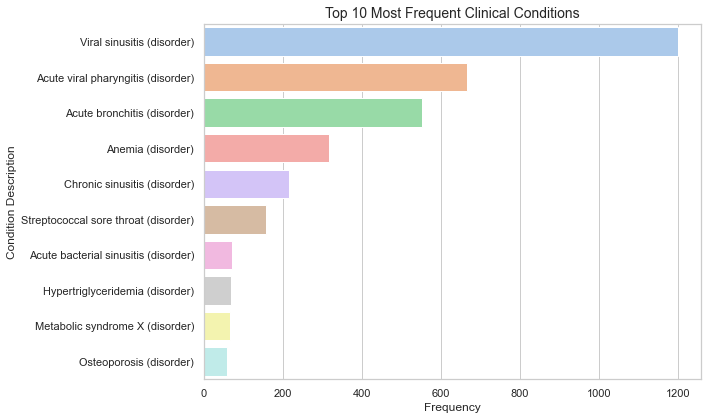

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="pastel")

# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_conditions,
    y="DESCRIPTION",
    x="Count",
    palette="pastel"
)

# Titles and labels
plt.title("Top 10 Most Frequent Clinical Conditions", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Condition Description")
plt.tight_layout()
plt.show()

# Section 3: Load and Clean Observations CSV

In [192]:
# Task 1 Load conditions csv 
observations_url = r"C:\Users\narin\Desktop\UCL_EMRs_Analysis\observations.csv"
observations = pd.read_csv(observations_url)

In [193]:
observations.head()

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,VALUE,UNITS,TYPE
0,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,8302-2,51.4,cm,numeric
1,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,72514-3,1.0,{score},numeric
2,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,29463-7,3.8,kg,numeric
3,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,77606-2,57.9,%,numeric
4,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,9843-4,34.8,cm,numeric


In [194]:
observations.shape

(531144, 8)

## 3.1 Load LOINC Dictionary

In [195]:
# Read LOINC dictionary CSV (columns: CODE, DESCRIPTION)
loinc_df = pd.read_csv(r"C:\Users\narin\Desktop\UCL_EMRs_Analysis\dictionary_loinc.csv")
loinc_df.head(2)

,CODE,DESCRIPTION
0,8302-2,Body Height
1,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...


In [196]:
# Merge on CODE column
observations = observations.merge(loinc_df[['CODE', 'DESCRIPTION']], on='CODE', how='left')

# Rename DESCRIPTION column from loinc_df to LOINC to avoid confusion
observations = observations.rename(columns={'DESCRIPTION': 'LOINC'})

observations.head(10)

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,VALUE,UNITS,TYPE,LOINC
0,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,8302-2,51.4,cm,numeric,Body Height
1,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,72514-3,1.0,{score},numeric,Pain severity - 0-10 verbal numeric rating [Sc...
2,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,29463-7,3.8,kg,numeric,Body Weight
3,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,77606-2,57.9,%,numeric,Weight-for-length Per age and sex
4,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,9843-4,34.8,cm,numeric,Head Occipital-frontal circumference
5,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,8462-4,89.0,mm[Hg],numeric,Diastolic Blood Pressure
6,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,8480-6,115.0,mm[Hg],numeric,Systolic Blood Pressure
7,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,8867-4,94.0,/min,numeric,Heart rate
8,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,9279-1,15.0,/min,numeric,Respiratory rate
9,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,laboratory,6690-2,5.8,10*3/uL,numeric,Leukocytes [#/volume] in Blood by Automated count


## 3.2 Misssingness

In [197]:
# check for missingness

print(observations.isnull().sum())

DATE              0
PATIENT           0
ENCOUNTER     31662
CATEGORY      31662
CODE            724
VALUE             0
UNITS        193883
TYPE              0
LOINC         32560
dtype: int64


In [198]:
observations[observations['ENCOUNTER'].isna() & observations['CATEGORY'].isna()]

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,VALUE,UNITS,TYPE,LOINC
132,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,0.0,a,numeric,NaN
133,2020-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,0.0,a,numeric,NaN
134,2021-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,1.0,a,numeric,NaN
135,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,0.0,a,numeric,NaN
136,2020-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,0.0,a,numeric,NaN
...,...,...,...,...,...,...,...,...,...
574551,2017-11-07T05:11:58Z,cb1b2c74-d1c5-997c-6f8b-20ca9f332eef,NaN,NaN,-7,1.0,{score},numeric,NaN
574552,2018-11-07T05:11:58Z,cb1b2c74-d1c5-997c-6f8b-20ca9f332eef,NaN,NaN,-7,1.0,{score},numeric,NaN
574553,2019-11-07T05:11:58Z,cb1b2c74-d1c5-997c-6f8b-20ca9f332eef,NaN,NaN,-7,1.0,{score},numeric,NaN
574554,2020-11-07T05:11:58Z,cb1b2c74-d1c5-997c-6f8b-20ca9f332eef,NaN,NaN,-7,1.0,{score},numeric,NaN


In [199]:
# View all unique values in the CODE column
print(observations['CODE'].unique())

['8302-2' '72514-3' '29463-7' '77606-2' '9843-4' '8462-4' '8480-6'
 '8867-4' '9279-1' '6690-2' '789-8' '718-7' '4544-3' '787-2' '785-6'
 '786-4' '21000-5' '777-3' '32207-3' '32623-1' '72166-2' '6206-7' '6273-7'
 '6082-2' '6246-3' '6276-0' '6106-9' '6248-9' '7258-7' '6189-5' '6085-5'
 '6833-8' '6095-4' '6075-6' '6844-5' '6158-0' '39156-5' '59576-9' '-7'
 '70274-6' '89204-2' '76501-6' '93026-3' '93027-1' '93028-9' '93038-8'
 '93029-7' '93030-5' '93031-3' '63586-2' '76437-3' '67875-5' '82589-3'
 '56799-0' '93033-9' '71802-3' '63512-8' '54899-0' '93034-7' '93035-4'
 '32624-9' '56051-6' '55758-7' '8310-5' '76504-0' '75626-2' '82667-7'
 '2708-6' '92142-9' '92141-1' '92131-2' '92140-3' '92139-5' '92138-7'
 '92130-4' '92134-6' '94040-3' '94531-1' '2093-3' '2571-8' '18262-6'
 '2085-9' '4548-4' '2339-0' '6299-2' '38483-4' '49765-1' '2947-0' '6298-4'
 '2069-3' '20565-8' '14959-1' '33914-3' '91146-1' '91145-3' '75893-8'
 '65750-2' '38208-5' '44261-6' nan '20570-8' '2885-2' '1751-7' '10834-0'
 '197

In [200]:
#Inspect '-7' for missingness in encounter and category

filtered_df = observations[observations['CODE'] == '-7']
filtered_df.head(5)

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,VALUE,UNITS,TYPE,LOINC
132,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,0.0,a,numeric,NaN
133,2020-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,0.0,a,numeric,NaN
134,2021-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,1.0,a,numeric,NaN
135,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,0.0,a,numeric,NaN
136,2020-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,NaN,NaN,-7,0.0,a,numeric,NaN


In [201]:
filtered_df['CODE'].value_counts()

-7    31732
Name: CODE, dtype: int64

In [202]:
filtered_df['ENCOUNTER'].value_counts()

94fab6e8-9cf5-622a-c5a9-0bf034781739    48
c5950dcc-240d-bbc6-7236-da7078ffbdb8    22
Name: ENCOUNTER, dtype: int64

In [203]:
filtered_df['CATEGORY'].value_counts()

laboratory     27
survey         26
vital-signs    17
Name: CATEGORY, dtype: int64

# Important **

### Category contains all NaN values other than 70 rows when filtered with -7 (invalid LOINC code) and there are 70 entries in encounter column. Therefore, dropping rows with NaN values in CATEGORY is the suggested decision. 

In [204]:
observations = observations.dropna(subset=['CATEGORY'])

In [205]:
observations.shape

(542894, 9)

In [206]:
print(observations.isnull().sum())

DATE              0
PATIENT           0
ENCOUNTER         0
CATEGORY          0
CODE            724
VALUE             0
UNITS        193883
TYPE              0
LOINC           898
dtype: int64


In [207]:
#Inspect again for '-7' because it shows that encounter and category has relevant information. 

filtered_df2 = observations[observations['CODE'] == '-7']
filtered_df2.head(5)

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,VALUE,UNITS,TYPE,LOINC
169877,2017-05-06T23:08:56Z,4b0917d5-d8b8-ca5a-9bce-658885b34afe,c5950dcc-240d-bbc6-7236-da7078ffbdb8,vital-signs,-7,188.4,cm,numeric,NaN
169878,2017-05-06T23:08:56Z,4b0917d5-d8b8-ca5a-9bce-658885b34afe,c5950dcc-240d-bbc6-7236-da7078ffbdb8,vital-signs,-7,3.0,{score},numeric,NaN
169879,2017-05-06T23:08:56Z,4b0917d5-d8b8-ca5a-9bce-658885b34afe,c5950dcc-240d-bbc6-7236-da7078ffbdb8,vital-signs,-7,70.1,kg,numeric,NaN
169880,2017-05-06T23:08:56Z,4b0917d5-d8b8-ca5a-9bce-658885b34afe,c5950dcc-240d-bbc6-7236-da7078ffbdb8,vital-signs,-7,19.7,kg/m2,numeric,NaN
169881,2017-05-06T23:08:56Z,4b0917d5-d8b8-ca5a-9bce-658885b34afe,c5950dcc-240d-bbc6-7236-da7078ffbdb8,vital-signs,-7,36.6,%,numeric,NaN


In [208]:
# Missingness in code

filtered_df = observations[observations['CODE'].isna()]
filtered_df.head(5)

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,VALUE,UNITS,TYPE,LOINC
2086,2012-03-23T08:53:53Z,61a2fcc0-d679-764c-7d86-b885b2c4907f,17d2f79e-65b2-42c1-ccb4-2ac780469d9b,vital-signs,NaN,158.7,cm,numeric,NaN
2087,2012-03-23T08:53:53Z,61a2fcc0-d679-764c-7d86-b885b2c4907f,17d2f79e-65b2-42c1-ccb4-2ac780469d9b,vital-signs,NaN,2.0,{score},numeric,NaN
2088,2012-03-23T08:53:53Z,61a2fcc0-d679-764c-7d86-b885b2c4907f,17d2f79e-65b2-42c1-ccb4-2ac780469d9b,vital-signs,NaN,53.4,kg,numeric,NaN
2089,2012-03-23T08:53:53Z,61a2fcc0-d679-764c-7d86-b885b2c4907f,17d2f79e-65b2-42c1-ccb4-2ac780469d9b,vital-signs,NaN,21.2,kg/m2,numeric,NaN
2090,2012-03-23T08:53:53Z,61a2fcc0-d679-764c-7d86-b885b2c4907f,17d2f79e-65b2-42c1-ccb4-2ac780469d9b,vital-signs,NaN,45.3,%,numeric,NaN


In [209]:
body_weight_rows = observations[observations['UNITS'].str.contains("cm", case=False, na=False)]
body_weight_rows.head(2)

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,VALUE,UNITS,TYPE,LOINC
0,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,8302-2,51.4,cm,numeric,Body Height
4,2019-02-17T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,748f8357-6cc7-551d-f31a-32fa2cf84126,vital-signs,9843-4,34.8,cm,numeric,Head Occipital-frontal circumference


## body height and Head Occipital-frontal circumference are usig same units and values overlap, it is a risk to add in the missing LOINC codes 

In [210]:
#n the LOINC codes for height 
# Filter for rows where LOINC is Body Height
body_height_df = observations[observations['LOINC'] == 'Body Height']

# Ensure VALUE is numeric
body_height_df['VALUE'] = pd.to_numeric(body_height_df['VALUE'], errors='coerce')

# Get descriptive statistics
body_height_df['VALUE'].describe()

C:\Users\narin\AppData\Local\Temp/ipykernel_16548/2827632837.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  body_height_df['VALUE'] = pd.to_numeric(body_height_df['VALUE'], errors='coerce')


count    12676.000000
mean       153.964997
std         33.844175
min         47.600000
25%        153.800000
50%        165.300000
75%        174.600000
max        198.700000
Name: VALUE, dtype: float64

In [211]:
# Filter for rows where LOINC is Head Occipital-frontal circumference
head_df = observations[observations['LOINC'] == 'Head Occipital-frontal circumference']

# Ensure VALUE is numeric
head_df['VALUE'] = pd.to_numeric(head_df['VALUE'], errors='coerce')

# Get descriptive statistics
head_df['VALUE'].describe()

C:\Users\narin\AppData\Local\Temp/ipykernel_16548/728458827.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_df['VALUE'] = pd.to_numeric(head_df['VALUE'], errors='coerce')


count    1651.000000
mean       44.986432
std         4.473197
min        31.000000
25%        42.350000
50%        46.100000
75%        48.200000
max        52.800000
Name: VALUE, dtype: float64

In [212]:
# kg & body weight / kg/m2 & Body Mass Index

body_weight_rows = observations[observations['UNITS'].str.contains("kg/m2", case=False, na=False)]
body_weight_rows.head(50)

# heart rate and respitory rate use the same unit - /min

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,VALUE,UNITS,TYPE,LOINC
125,2021-07-25T05:07:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,53c2bae0-f0ff-7eac-4ca1-3dce0ecebb30,vital-signs,39156-5,16.3,kg/m2,numeric,Body Mass Index
144,2012-06-25T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,c7b935e1-02ce-8ec2-bc48-69671e986469,vital-signs,39156-5,16.2,kg/m2,numeric,Body Mass Index
154,2013-07-01T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,7d6494ff-bf75-6120-dcc9-e73db03479b5,vital-signs,39156-5,16.1,kg/m2,numeric,Body Mass Index
164,2014-07-07T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,34894bce-59ce-59c6-7f0e-96dc4100df18,vital-signs,39156-5,16.2,kg/m2,numeric,Body Mass Index
174,2015-07-13T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,f4357834-ba77-f8a7-6b64-9b1809bf136f,vital-signs,39156-5,16.5,kg/m2,numeric,Body Mass Index
184,2016-07-18T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,0bda12c9-bd88-a50f-57e5-9f4245b78b66,vital-signs,39156-5,17.6,kg/m2,numeric,Body Mass Index
209,2017-07-24T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,676b26cf-85c1-60d8-b4b2-ed9b34d5b3a7,vital-signs,39156-5,18.8,kg/m2,numeric,Body Mass Index
221,2018-07-30T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,644a93a4-a003-5329-9c2b-0b3550be22e7,vital-signs,39156-5,19.7,kg/m2,numeric,Body Mass Index
231,2019-08-05T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,48203e0f-d694-f967-ba4d-04aa135dc064,vital-signs,39156-5,20.3,kg/m2,numeric,Body Mass Index
241,2020-08-10T08:20:52Z,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,231a57d6-cf55-e711-ae9f-27f9396f1f4d,vital-signs,39156-5,22.7,kg/m2,numeric,Body Mass Index


In [213]:
# Replace CODE and LOINC for rows with NaN CODE and UNITS == 'kg/m2'
observations.loc[
    (observations['CODE'].isna()) & (observations['UNITS'] == 'kg/m2'),
    ['CODE', 'LOINC']
] = ['39156-5', 'Body Mass Index']


## Filling in missing units from known LOINC codes description and CODE category did not remove all missingness because many of the units may mean different for different codes 

In [216]:
print(observations.isnull().sum())

DATE              0
PATIENT           0
ENCOUNTER         0
CATEGORY          0
CODE            706
VALUE             0
UNITS        193883
TYPE              0
LOINC           880
dtype: int64


In [217]:
observations = observations.fillna("Unknown")

# Task 2 The most frequent ontology terms in  LOINC

In [218]:
observations['LOINC'].value_counts()

Pain severity - 0-10 verbal numeric rating [Score] - Reported                  14514
Diastolic Blood Pressure                                                       14444
Systolic Blood Pressure                                                        14444
Body Weight                                                                    13252
Heart rate                                                                     12991
                                                                               ...  
Lymph nodes with macrometastases [#] in Cancer specimen by Light microscopy        2
Tumor marker Cancer                                                                2
Lymph nodes with micrometastases [#] in Cancer specimen by Light microscopy        2
Thyroxine (T4) free [Mass/volume] in Serum or Plasma                               1
Thyrotropin [Units/volume] in Serum or Plasma                                      1
Name: LOINC, Length: 245, dtype: int64

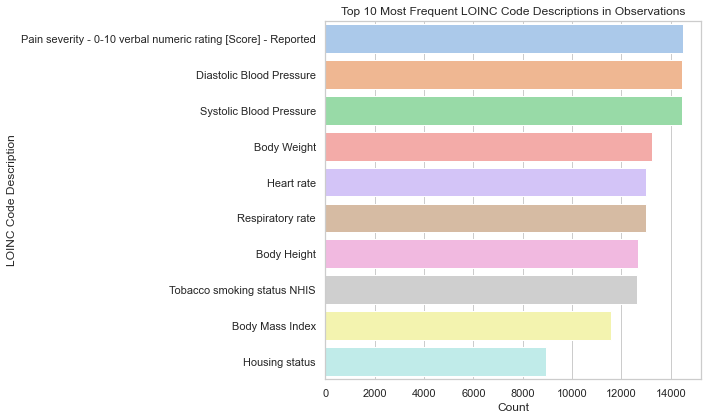

In [223]:
# Count top 10 LOINC codes
top_loinc = observations['LOINC'].value_counts().head(10).reset_index()
top_loinc.columns = ['LOINC', 'Count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_loinc, x='Count', y='LOINC', palette='pastel')

plt.title('Top 10 Most Frequent LOINC Code Descriptions in Observations')
plt.xlabel('Count')
plt.ylabel('LOINC Code Description')
plt.tight_layout()
plt.show()

# Observations Cleaned

In [247]:
observations.to_csv('observations_cleaned.csv', index=False)

## 3.3 Merge Observations with Orignal clean dataset (patients & conditions)

In [233]:
print(merge_clean.columns.tolist())

['START', 'STOP', 'Id', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'AGE']


In [234]:
print(observations.columns.tolist())

['LAB_DATE', 'Id', 'OBS_ENCOUNTER', 'CATEGORY', 'LOINC_CODE', 'VALUE', 'UNITS', 'TYPE', 'LOINC_DESCRIPTION']


In [235]:
# Checking for duplicate column names and changing them 

In [236]:
observations = observations.rename(columns={'PATIENT': 'Id'})

In [237]:
observations = observations.rename(columns={'CODE': 'LOINC_CODE'})

In [238]:
observations = observations.rename(columns={'ENCOUNTER': 'OBS_ENCOUNTER'})

In [239]:
observations = observations.rename(columns={'LOINC': 'LOINC_DESCRIPTION'})

In [240]:
observations = observations.rename(columns={'DATE': 'LAB_DATE'})

In [241]:
print(observations.columns.tolist())

['LAB_DATE', 'Id', 'OBS_ENCOUNTER', 'CATEGORY', 'LOINC_CODE', 'VALUE', 'UNITS', 'TYPE', 'LOINC_DESCRIPTION']


In [242]:
merge_3 = pd.merge(observations, merge_clean, on='Id', how='right')

In [243]:
merge_3.shape

(37273931, 39)

In [244]:
print(merge_3.columns.tolist())

['LAB_DATE', 'Id', 'OBS_ENCOUNTER', 'CATEGORY', 'LOINC_CODE', 'VALUE', 'UNITS', 'TYPE', 'LOINC_DESCRIPTION', 'START', 'STOP', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'AGE']


In [245]:
# List of selected columns
selected_columns = [
    'LAB_DATE', 'Id', 'OBS_ENCOUNTER', 'CATEGORY', 'LOINC_CODE', 'VALUE',
    'UNITS', 'TYPE', 'LOINC_DESCRIPTION', 'START', 'STOP', 'ENCOUNTER',
    'CODE', 'DESCRIPTION', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'AGE'
]

# Create a new DataFrame with just those columns
htn_df = merge_3[selected_columns].copy()


In [246]:
htn_df.shape

(37273931, 19)

## Hypertension Types Transformation

In [249]:
# Filter rows where 'DESCRIPTION' contains the word "hypertension" (case-insensitive)
hypertension_df = htn_df[htn_df['DESCRIPTION'].str.contains("hypertension", case=False, na=False)]


In [250]:
hypertension_df.head(10)

,LAB_DATE,Id,OBS_ENCOUNTER,CATEGORY,LOINC_CODE,VALUE,UNITS,TYPE,LOINC_DESCRIPTION,START,STOP,ENCOUNTER,CODE,DESCRIPTION,MARITAL,RACE,ETHNICITY,GENDER,AGE
942,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,8302-2,166.8,cm,numeric,Body Height,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
943,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,72514-3,3.0,{score},numeric,Pain severity - 0-10 verbal numeric rating [Sc...,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
944,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,29463-7,70.9,kg,numeric,Body Weight,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
945,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,39156-5,25.5,kg/m2,numeric,Body Mass Index,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
946,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,59576-9,94.0,%,numeric,Body mass index (BMI) [Percentile] Per age and...,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
947,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,8462-4,82.0,mm[Hg],numeric,Diastolic Blood Pressure,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
948,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,8480-6,129.0,mm[Hg],numeric,Systolic Blood Pressure,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
949,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,8867-4,87.0,/min,numeric,Heart rate,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
950,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,9279-1,15.0,/min,numeric,Respiratory rate,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23
951,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,survey,72166-2,Never smoker,Unknown,text,Tobacco smoking status NHIS,04/07/2016,Ongoing,8195411f-4a65-9245-07d3-1999e1c223df,59621000,Hypertension,Unknown,white,nonhispanic,M,23


In [251]:
# Another way to search for hypertension

# Create a boolean mask where 'DESCRIPTION' contains "hypertension"
mask = htn_df['DESCRIPTION'].str.contains("hypertension", case=False, na=False)

# Apply the mask to filter the dataframe
hypertension_df = htn_df[mask]


In [252]:
# Hypertension SNOMED code to label mapping
htn_labels = {
    '38341003': 'Hypertension - General',
    '59621000': 'Malignant Hypertension',
    '1201005': 'Benign Hypertension',
    '260245000': 'Secondary Hypertension',
    '165962004': 'Renal Hypertension',
    '109838007': 'Pregnancy-induced Hypertension',
    '1958004': 'Pulmonary Hypertension'
}

In [254]:
# Ensure CODE is string
htn_df['CODE'] = htn_df['CODE'].astype(str)

# Map the hypertension label based on CODE
htn_df['HYPERTENSION_TYPE'] = htn_df['CODE'].map(htn_labels)


In [255]:
htn_df['HYPERTENSION_TYPE'].value_counts()

Malignant Hypertension            202720
Pregnancy-induced Hypertension      4984
Name: HYPERTENSION_TYPE, dtype: int64

## Majority patients have malignant hypertnesion

# Task 3a) Distribution of Systolic Blood Pressure using UK NICE Guidelines

In [259]:
## Get most recent recording

In [258]:
# Ensure date column is datetime
systolic_df['LAB_DATE'] = pd.to_datetime(systolic_df['LAB_DATE'])

# Sort by date so the latest is first
systolic_df = systolic_df.sort_values(by=['Id', 'LAB_DATE'], ascending=[True, False])

# Keep the first (most recent) measurement per patient
latest_systolic = systolic_df.drop_duplicates(subset='Id', keep='first')


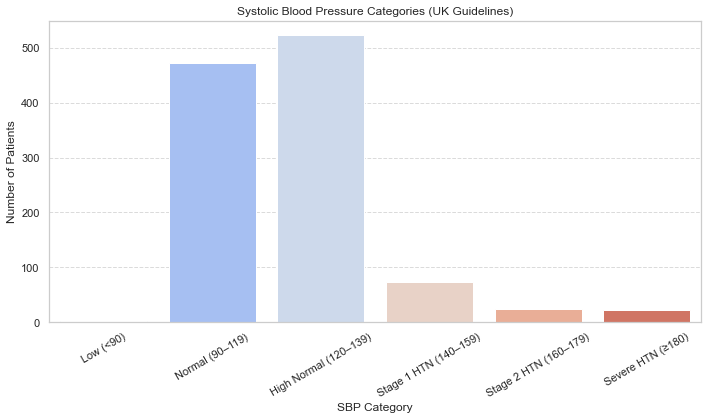

In [293]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter for systolic BP (LOINC code: 8480-6)
systolic_df = latest_systolic[latest_systolic['LOINC_CODE'] == '8480-6'].copy()

# 2. Convert VALUE to numeric and drop invalid entries
systolic_df['VALUE'] = pd.to_numeric(systolic_df['VALUE'], errors='coerce')
systolic_df = systolic_df.dropna(subset=['VALUE'])

# 3. Define UK SBP categories
def uk_categorize_sbp(value):
    if value < 90:
        return 'Low (<90)'
    elif 90 <= value <= 119:
        return 'Normal (90–119)'
    elif 120 <= value <= 139:
        return 'High Normal (120–139)'
    elif 140 <= value <= 159:
        return 'Stage 1 HTN (140–159)'
    elif 160 <= value <= 179:
        return 'Stage 2 HTN (160–179)'
    else:
        return 'Severe HTN (≥180)'

# 4. Apply categorisation
systolic_df['SBP_Category'] = systolic_df['VALUE'].apply(uk_categorize_sbp)

# 5. Count categories
category_counts = systolic_df['SBP_Category'].value_counts().reindex([
    'Low (<90)',
    'Normal (90–119)',
    'High Normal (120–139)',
    'Stage 1 HTN (140–159)',
    'Stage 2 HTN (160–179)',
    'Severe HTN (≥180)'
], fill_value=0)

# 6. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='coolwarm')

plt.title('Systolic Blood Pressure Categories (UK Guidelines)')
plt.xlabel('SBP Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Task 3a) Distribution of Diastolic Blood Pressure

In [294]:
import pandas as pd

# Filter for diastolic BP (LOINC code: 8462-4)
diastolic_df = htn_df[htn_df['LOINC_CODE'] == '8462-4'].copy()

# Ensure date column is datetime
diastolic_df['LAB_DATE'] = pd.to_datetime(diastolic_df['LAB_DATE'])

# Sort by patient Id and date descending (latest first)
diastolic_df = diastolic_df.sort_values(by=['Id', 'LAB_DATE'], ascending=[True, False])

# Keep only the most recent diastolic BP per patient
latest_diastolic = diastolic_df.drop_duplicates(subset='Id', keep='first')


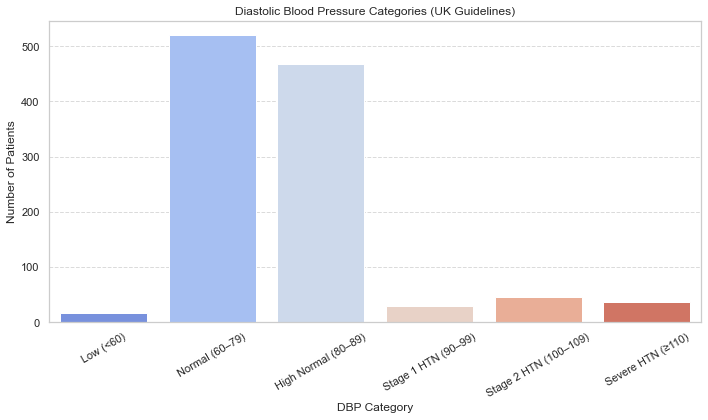

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter for diastolic BP (LOINC code: 8462-4)
diastolic_df = latest_diastolic[latest_diastolic['LOINC_CODE'] == '8462-4'].copy()

# 2. Convert VALUE to numeric and drop invalid entries
diastolic_df['VALUE'] = pd.to_numeric(diastolic_df['VALUE'], errors='coerce')
diastolic_df = diastolic_df.dropna(subset=['VALUE'])

# 3. Define UK DBP categories
def uk_categorize_dbp(value):
    if value < 60:
        return 'Low (<60)'
    elif 60 <= value <= 79:
        return 'Normal (60–79)'
    elif 80 <= value <= 89:
        return 'High Normal (80–89)'
    elif 90 <= value <= 99:
        return 'Stage 1 HTN (90–99)'
    elif 100 <= value <= 109:
        return 'Stage 2 HTN (100–109)'
    else:
        return 'Severe HTN (≥110)'

# 4. Apply categorization
diastolic_df['DBP_Category'] = diastolic_df['VALUE'].apply(uk_categorize_dbp)

# 5. Count categories
category_counts = diastolic_df['DBP_Category'].value_counts().reindex([
    'Low (<60)',
    'Normal (60–79)',
    'High Normal (80–89)',
    'Stage 1 HTN (90–99)',
    'Stage 2 HTN (100–109)',
    'Severe HTN (≥110)'
], fill_value=0)

# 6. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='coolwarm')

plt.title('Diastolic Blood Pressure Categories (UK Guidelines)')
plt.xlabel('DBP Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Fill missing with 'Other/Non-Hypertension'
conditions['HYPERTENSION_TYPE'] = conditions['HYPERTENSION_TYPE'].fillna('Other/Non-Hypertension')

In [107]:
merge_3.head(4)

,LAB_DATE,Id,OBS_ENCOUNTER,CATEGORY,LOINC_CODE,VALUE,UNITS,TYPE,LOINC_DESCRIPTION,START,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE
0,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,8302-2,166.8,cm,numeric,Body Height,11/06/2012,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.06116,571935.8725,787.5375,23
1,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,72514-3,3.0,{score},numeric,Pain severity - 0-10 verbal numeric rating [Sc...,11/06/2012,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.06116,571935.8725,787.5375,23
2,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,29463-7,70.9,kg,numeric,Body Weight,11/06/2012,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.06116,571935.8725,787.5375,23
3,2012-06-11T05:03:31Z,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,39156-5,25.5,kg/m2,numeric,Body Mass Index,11/06/2012,...,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.06116,571935.8725,787.5375,23


In [108]:
merge_3.to_csv('merged_conditions_patients_observations.csv', index=False)

In [114]:
print(merge_3.isnull().sum())

LAB_DATE               0
Id                     0
OBS_ENCOUNTER          0
CATEGORY               0
LOINC_CODE             0
VALUE                  0
UNITS                  0
TYPE                   0
LOINC_DESCRIPTION      0
START                  0
STOP                   0
ENCOUNTER              0
CODE                   0
DESCRIPTION            0
BIRTHDATE              0
DEATHDATE              0
SSN                    0
DRIVERS                0
PASSPORT               0
PREFIX                 0
FIRST                  0
LAST                   0
SUFFIX                 0
MAIDEN                 0
MARITAL                0
RACE                   0
ETHNICITY              0
GENDER                 0
BIRTHPLACE             0
ADDRESS                0
CITY                   0
STATE                  0
COUNTY                 0
ZIP                    0
LAT                    0
LON                    0
HEALTHCARE_EXPENSES    0
HEALTHCARE_COVERAGE    0
AGE                    0
dtype: int64


# Section 4: Medications

In [261]:
# Task 1 Load medications csv 
medications_url = r"C:\Users\narin\Desktop\UCL_EMRs_Analysis\medications.csv"
medications = pd.read_csv(medications_url)

In [262]:
medications.head(1)

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE
0,2020-02-17T10:40:32Z,NaN,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,01efcc52-15d6-51e9-faa2-bee069fcbe44,1014676.0,21.45,0.0,21,450.45,NaN


In [263]:
medications.shape

(56430, 11)

In [264]:
print(medications.isnull().sum())

START                 0
STOP               2713
PATIENT               0
PAYER                 0
ENCOUNTER             0
CODE                 48
BASE_COST             0
PAYER_COVERAGE        0
DISPENSES             0
TOTALCOST             0
REASONCODE        15475
dtype: int64


In [265]:
medications['STOP'] = pd.to_datetime(medications['STOP'], errors='coerce')
medications['STOP'].max()

Timestamp('2021-11-18 15:08:27+0000', tz='UTC')

In [266]:
medications['STOP'] = medications['STOP'].fillna('ongoing')

## 4.1 Missingness in code

In [267]:
# 4.1 Missingness in code

filtered_df = medications[medications['CODE'].isna()]
filtered_df.head(50)

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE
3708,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,NaN,463.65,338.92,1,463.65,44054006.0
3709,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,NaN,0.01,0.00,1,0.01,59621000.0
3710,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,NaN,53.49,10.79,1,53.49,NaN
3711,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,NaN,94.91,43.93,1,94.91,44054006.0
3712,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,NaN,96.46,45.17,1,96.46,NaN
3713,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,NaN,0.02,0.00,28,0.56,59621000.0
3714,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,NaN,15.96,0.00,1,15.96,NaN
5167,2019-12-10T23:06:33Z,2020-12-15 23:06:33+00:00,fbee8d6b-5acf-370c-7edd-af0d84f5288c,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ce90fe4d-3302-ff35-3885-afe16472e997,NaN,263.49,0.00,3,790.47,NaN
5168,2019-12-10T23:06:33Z,2020-12-15 23:06:33+00:00,fbee8d6b-5acf-370c-7edd-af0d84f5288c,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ce90fe4d-3302-ff35-3885-afe16472e997,NaN,0.02,0.00,371,7.42,59621000.0
5169,2019-12-10T23:06:33Z,2020-12-15 23:06:33+00:00,fbee8d6b-5acf-370c-7edd-af0d84f5288c,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ce90fe4d-3302-ff35-3885-afe16472e997,NaN,0.02,0.00,371,7.42,59621000.0


### There were duplicates via patient id, medication code at the same start and stop date

In [268]:
medications = medications.drop_duplicates(subset=['PATIENT', 'CODE', 'START', 'STOP'])

In [269]:
medications.shape

(56356, 11)

In [270]:
print(medications.isnull().sum())

START                 0
STOP                  0
PATIENT               0
PAYER                 0
ENCOUNTER             0
CODE                 20
BASE_COST             0
PAYER_COVERAGE        0
DISPENSES             0
TOTALCOST             0
REASONCODE        15446
dtype: int64


In [271]:
# This has reduced missingness in 'CODE'

In [272]:
# Missingness in code

filtered_df = medications[medications['CODE'].isna()]
filtered_df.head(5)

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE
3708,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,NaN,463.65,338.92,1,463.65,44054006.0
5167,2019-12-10T23:06:33Z,2020-12-15 23:06:33+00:00,fbee8d6b-5acf-370c-7edd-af0d84f5288c,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ce90fe4d-3302-ff35-3885-afe16472e997,NaN,263.49,0.00,3,790.47,NaN
7352,1995-02-05T04:46:50Z,1996-02-11 04:46:50+00:00,d02b2ca5-7e63-1c3d-505f-3a7218bac46d,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,0ccad5f1-bca9-0e80-1472-38e56913ef6f,NaN,0.02,0.00,371,7.42,59621000.0
8546,1983-12-06T20:45:19Z,1984-01-03 20:45:19+00:00,ef167059-cef0-12c4-49db-993ca3a20c01,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,dcb8a713-4796-28da-23b3-c943ca6a3ec3,NaN,416.13,0.00,1,416.13,44054006.0
13578,2014-01-21T17:58:04Z,2014-01-21 17:58:04+00:00,79823958-40ce-9882-a2da-9ff37be49b19,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,df801b08-24e2-3f1c-4724-bba1304548db,NaN,0.01,0.00,1,0.01,59621000.0


In [273]:
medications['CODE'] = medications['CODE'].fillna('Unknown')

## 4.2 Merge with dictionary to get medication names

In [274]:
# Read medication dictionary CSV (columns: CODE, DESCRIPTION)
med_df = pd.read_csv(r"C:\Users\narin\Desktop\UCL_EMRs_Analysis\dictionary_rxnorm.csv")
med_df.head(2)

,CODE,DESCRIPTION
0,1014676,cetirizine hydrochloride 5 MG Oral Tablet
1,1870230,NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Inje...


In [275]:
print(medications.columns.tolist())

['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST', 'REASONCODE']


In [276]:
medications = medications.rename(columns={'PATIENT': 'Id'})

In [277]:
print(med_df.columns.tolist())

['CODE', 'DESCRIPTION']


In [278]:
medications.shape

(56356, 11)

In [279]:
unique_codes = medications['CODE'].unique()
print(unique_codes)

['1014676.0' '1870230.0' '1043400.0' '198405.0' '313820.0' '849574.0'
 '1000126.0' '313782.0' '310798.0' '308136.0' '314076.0' '562251.0'
 '310965.0' '1049630.0' '311989.0' '1094107.0' '209387.0' '311995.0'
 '834061.0' '757594.0' '748962.0' '748879.0' '831533.0' '1856546.0'
 '749762.0' '807283.0' '1605257.0' '748856.0' '1534809.0' '389221.0'
 '1367439.0' '1359133.0' '1803932.0' '1736776.0' '978950.0' '751905.0'
 '314231.0' '608139.0' '1049625.0' '1049504.0' '895994.0' '2123111.0'
 '854235.0' '198440.0' '854252.0' '834102.0' '477045.0' '855332.0'
 '897718.0' '197604.0' '997488.0' '1659263.0' '313002.0' '1740467.0'
 '1732136.0' '1659149.0' '311700.0' '1808217.0' '1234995.0' '542347.0'
 '1729584.0' '861467.0' '2001499.0' '106258.0' '1014678.0' '206905.0'
 '749882.0' '749785.0' '1366343.0' '197591.0' '1659131.0' '1807510.0'
 '860975.0' '904419.0' '665078.0' '1049221.0' '309097.0' '312617.0'
 '583214.0' '597195.0' '309362.0' '1804799.0' '308192.0' '106892.0'
 '198014.0' '833135.0' '1809104.

In [280]:
# Extract codes with suspicious patterns (e.g., containing '-')
bad_codes = medications[medications['CODE'].str.contains('-', na=False)]
print(bad_codes['CODE'].unique())

['2833710--05010' '-7']


In [281]:
medications.loc[medications['CODE'].str.contains('-', na=False), 'CODE'] = 'Unknown'

In [282]:
medications['CODE'] = medications['CODE'].replace('Unknown', 0.0)

In [283]:
# Convert CODE to string without decimal places
medications['CODE'] = medications['CODE'].astype(float).astype(int).astype(str)
med_df['CODE'] = med_df['CODE'].astype(str)

In [284]:
medications = medications.merge(med_df[['CODE', 'DESCRIPTION']], on='CODE', how='left')

In [285]:
medications = medications.rename(columns={'DESCRIPTION': 'MEDICATION'})

## 4.3 Fixing REASON CODE

In [286]:
unique_codes = medications['REASONCODE'].unique()
print(unique_codes)

[           nan 1.05090020e+07 5.96210000e+07 4.44814009e+08
 3.01011002e+08 3.88220070e+07 1.95662009e+08 9.42600040e+07
 4.38780080e+07 5.58220040e+07 1.92127007e+08 2.33678006e+08
 3.89087006e+08 1.32281000e+14 2.39872002e+08 2.39873007e+08
 4.02750040e+07 9.13020080e+07 4.40540060e+07 2.54837009e+08
 9.54170030e+07 3.69710090e+07 2.01834006e+08 3.63406005e+08
 4.24132000e+08 8.88050090e+07 7.54980040e+07 6.98960040e+07
 1.85086009e+08 8.74330010e+07 7.06870000e+08 1.95967001e+08
 4.58160000e+07 2.69290040e+07 5.60200100e+06 9.05600070e+07
 2.40790010e+07 2.71737000e+08 4.75050030e+07 2.30265002e+08
 7.65710070e+07 1.90905008e+08 1.12180090e+07 4.25048006e+08
 1.09838007e+08 8.40539006e+08]


In [287]:
medications['REASONCODE'] = medications['REASONCODE'].fillna('Unknown')

In [288]:
medications['REASONCODE'] = medications['REASONCODE'].astype(object).astype(str)

In [289]:
unique_codes = medications['MEDICATION'].unique()
print(unique_codes)

['cetirizine hydrochloride 5 MG Oral Tablet'
 'NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Injector'
 'Acetaminophen 21.7 MG/ML / Dextromethorphan Hydrobromide 1 MG/ML / doxylamine succinate 0.417 MG/ML Oral Solution'
 'Ibuprofen 100 MG Oral Tablet' 'Acetaminophen 160 MG Chewable Tablet'
 'Naproxen sodium 220 MG Oral Tablet'
 '1 ML medroxyPROGESTERone acetate 150 MG/ML Injection'
 '1 ML medroxyprogesterone acetate 150 MG/ML Injection'
 'Acetaminophen 325 MG Oral Tablet'
 'Hydrochlorothiazide 25 MG Oral Tablet' 'amLODIPine 2.5 MG Oral Tablet'
 'lisinopril 10 MG Oral Tablet'
 'Amoxicillin 250 MG / Clavulanate 125 MG Oral Tablet'
 'Ibuprofen 200 MG Oral Tablet'
 'diphenhydrAMINE Hydrochloride 25 MG Oral Tablet'
 'Nitrofurantoin 5 MG/ML Oral Suspension'
 'Phenazopyridine hydrochloride 100 MG Oral Tablet'
 'Acetaminophen 325 MG Oral Tablet [Tylenol]'
 'NITROFURANTOIN  MACROCRYSTALS 50 MG Oral Capsule'
 'Penicillin V Potassium 250 MG Oral Tablet' 'Jolivette 28 Day Pack'
 'Camila 28 Day Pack' '

In [296]:
medications.head(50)

,START,STOP,Id,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,MEDICATION
0,2020-02-17T10:40:32Z,ongoing,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,01efcc52-15d6-51e9-faa2-bee069fcbe44,1014676,21.45,0.00,21,450.45,Unknown,cetirizine hydrochloride 5 MG Oral Tablet
1,2020-02-17T10:40:32Z,ongoing,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,01efcc52-15d6-51e9-faa2-bee069fcbe44,1870230,231.58,0.00,21,4863.18,Unknown,NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Inje...
2,2013-06-24T06:39:19Z,2013-07-02 06:39:19+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a,0b2794bd-ec2b-d34f-0610-2523b3b7fcf0,1043400,7.59,0.00,1,7.59,10509002.0,Acetaminophen 21.7 MG/ML / Dextromethorphan Hy...
3,2016-02-27T08:52:29Z,2016-03-14 08:52:29+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,6e2f1a2d-27bd-3701-8d08-dae202c58632,a6d818dd-0983-fd1c-eefa-3d2295532c45,198405,12.48,0.00,1,12.48,Unknown,Ibuprofen 100 MG Oral Tablet
4,2017-02-22T09:25:31Z,2017-06-02 09:25:31+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,047f6ec3-6215-35eb-9608-f9dda363a44c,6474f606-5a1b-48c0-bbbf-ad6dcbc24d4e,313820,4.77,0.00,3,14.31,Unknown,Acetaminophen 160 MG Chewable Tablet
5,2020-02-06T09:25:31Z,2020-03-14 09:25:31+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,a6da4c61-bc91-17a7-14a2-fda9023536a3,849574,9.25,0.00,1,9.25,201834006.0,Naproxen sodium 220 MG Oral Tablet
6,2021-06-23T08:20:52Z,ongoing,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,047f6ec3-6215-35eb-9608-f9dda363a44c,68e737e5-a4a1-0ffd-7234-8fb04a2b0c19,1000126,227.63,0.00,5,1138.15,Unknown,1 ML medroxyPROGESTERone acetate 150 MG/ML Inj...
7,2021-06-23T08:20:52Z,ongoing,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,047f6ec3-6215-35eb-9608-f9dda363a44c,68e737e5-a4a1-0ffd-7234-8fb04a2b0c19,1000126,227.63,0.00,5,1138.15,Unknown,1 ML medroxyprogesterone acetate 150 MG/ML Inj...
8,2012-08-07T05:03:31Z,2012-09-02 05:03:31+00:00,339144f8-50e1-633e-a013-f361391c4cff,047f6ec3-6215-35eb-9608-f9dda363a44c,4224e87e-d63e-4b30-a01b-03daffac9d26,313782,4.81,0.00,1,4.81,10509002.0,Acetaminophen 325 MG Oral Tablet
9,2016-07-04T05:03:31Z,2017-07-10 05:03:31+00:00,339144f8-50e1-633e-a013-f361391c4cff,6e2f1a2d-27bd-3701-8d08-dae202c58632,8195411f-4a65-9245-07d3-1999e1c223df,310798,0.01,0.00,12,0.12,59621000.0,Hydrochlorothiazide 25 MG Oral Tablet


In [290]:
medications[medications['REASONCODE'].isna()]

,START,STOP,Id,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,MEDICATION


In [291]:
medications.dtypes


START              object
STOP               object
Id                 object
PAYER              object
ENCOUNTER          object
CODE               object
BASE_COST         float64
PAYER_COVERAGE    float64
DISPENSES           int64
TOTALCOST         float64
REASONCODE         object
MEDICATION         object
dtype: object

In [292]:
print(medications.isnull().sum())

START              0
STOP               0
Id                 0
PAYER              0
ENCOUNTER          0
CODE               0
BASE_COST          0
PAYER_COVERAGE     0
DISPENSES          0
TOTALCOST          0
REASONCODE         0
MEDICATION        26
dtype: int64


### Mapping reason codes from known reason code by CODE and MEDICATION

In [293]:
# Filter rows where REASONCODE is present (not NaN)
known_reason = medications[medications['REASONCODE'].notna()]

In [294]:
# Create dictionary mapping (CODE, MEDICATION) -> REASONCODE
reason_map = known_reason.set_index(['CODE', 'MEDICATION'])['REASONCODE'].to_dict()

In [295]:
# Define a function to fill missing REASONCODEs

def fill_reason(row):
    if pd.isna(row['REASONCODE']) or row['REASONCODE'] == 'Unknown':
        return reason_map.get((row['CODE'], row['MEDICATION']), 'Unknown')
    else:
        return row['REASONCODE']

In [296]:
medications['REASONCODE'] = medications.apply(fill_reason, axis=1)

In [297]:
medications.head(10)

,START,STOP,Id,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,MEDICATION
0,2020-02-17T10:40:32Z,ongoing,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,01efcc52-15d6-51e9-faa2-bee069fcbe44,1014676,21.45,0.0,21,450.45,Unknown,cetirizine hydrochloride 5 MG Oral Tablet
1,2020-02-17T10:40:32Z,ongoing,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,01efcc52-15d6-51e9-faa2-bee069fcbe44,1870230,231.58,0.0,21,4863.18,Unknown,NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Inje...
2,2013-06-24T06:39:19Z,2013-07-02 06:39:19+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a,0b2794bd-ec2b-d34f-0610-2523b3b7fcf0,1043400,7.59,0.0,1,7.59,10509002.0,Acetaminophen 21.7 MG/ML / Dextromethorphan Hy...
3,2016-02-27T08:52:29Z,2016-03-14 08:52:29+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,6e2f1a2d-27bd-3701-8d08-dae202c58632,a6d818dd-0983-fd1c-eefa-3d2295532c45,198405,12.48,0.0,1,12.48,Unknown,Ibuprofen 100 MG Oral Tablet
4,2017-02-22T09:25:31Z,2017-06-02 09:25:31+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,047f6ec3-6215-35eb-9608-f9dda363a44c,6474f606-5a1b-48c0-bbbf-ad6dcbc24d4e,313820,4.77,0.0,3,14.31,Unknown,Acetaminophen 160 MG Chewable Tablet
5,2020-02-06T09:25:31Z,2020-03-14 09:25:31+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,a6da4c61-bc91-17a7-14a2-fda9023536a3,849574,9.25,0.0,1,9.25,201834006.0,Naproxen sodium 220 MG Oral Tablet
6,2021-06-23T08:20:52Z,ongoing,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,047f6ec3-6215-35eb-9608-f9dda363a44c,68e737e5-a4a1-0ffd-7234-8fb04a2b0c19,1000126,227.63,0.0,5,1138.15,Unknown,1 ML medroxyPROGESTERone acetate 150 MG/ML Inj...
7,2021-06-23T08:20:52Z,ongoing,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,047f6ec3-6215-35eb-9608-f9dda363a44c,68e737e5-a4a1-0ffd-7234-8fb04a2b0c19,1000126,227.63,0.0,5,1138.15,Unknown,1 ML medroxyprogesterone acetate 150 MG/ML Inj...
8,2012-08-07T05:03:31Z,2012-09-02 05:03:31+00:00,339144f8-50e1-633e-a013-f361391c4cff,047f6ec3-6215-35eb-9608-f9dda363a44c,4224e87e-d63e-4b30-a01b-03daffac9d26,313782,4.81,0.0,1,4.81,10509002.0,Acetaminophen 325 MG Oral Tablet
9,2016-07-04T05:03:31Z,2017-07-10 05:03:31+00:00,339144f8-50e1-633e-a013-f361391c4cff,6e2f1a2d-27bd-3701-8d08-dae202c58632,8195411f-4a65-9245-07d3-1999e1c223df,310798,0.01,0.0,12,0.12,59621000.0,Hydrochlorothiazide 25 MG Oral Tablet


In [298]:
# Some 'unknown' codes were mapped and some medications do not have reason codes.

ibuprofen_rows = medications[medications['MEDICATION'].str.contains("Ibuprofen 100 MG Oral Tablet", na=False)]
ibuprofen_rows.head(2)


,START,STOP,Id,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,MEDICATION
3,2016-02-27T08:52:29Z,2016-03-14 08:52:29+00:00,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,6e2f1a2d-27bd-3701-8d08-dae202c58632,a6d818dd-0983-fd1c-eefa-3d2295532c45,198405,12.48,0.0,1,12.48,Unknown,Ibuprofen 100 MG Oral Tablet
56,2014-07-13T20:15:57Z,2014-08-30 20:15:57+00:00,dc6c06d0-a7d8-100f-c08b-46c93700c188,047f6ec3-6215-35eb-9608-f9dda363a44c,1997235c-9bd0-8051-644d-c47750bcb1fd,198405,13.25,0.0,1,13.25,Unknown,Ibuprofen 100 MG Oral Tablet


In [299]:
ibuprofen_rows = medications[medications['REASONCODE'].str.contains('44054006.0', na=False)]
ibuprofen_rows.head(2)

,START,STOP,Id,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,MEDICATION
543,2002-10-03T04:22:51Z,2002-10-03 04:22:51+00:00,1cfa5a70-7f3c-4227-5cf1-e182fcff4cd4,4d71f845-a6a9-3c39-b242-14d25ef86a8d,9cd8501d-49ca-9670-d591-b42d3df294a8,860975,223.34,0.0,1,223.34,44054006.0,24 HR Metformin hydrochloride 500 MG Extended ...
544,2002-10-03T04:22:51Z,2003-10-09 04:22:51+00:00,1cfa5a70-7f3c-4227-5cf1-e182fcff4cd4,4d71f845-a6a9-3c39-b242-14d25ef86a8d,9cd8501d-49ca-9670-d591-b42d3df294a8,860975,144.53,0.0,12,1734.36,44054006.0,24 HR Metformin hydrochloride 500 MG Extended ...


In [300]:
# Map Medications

In [301]:
medications[medications['MEDICATION'].isna()]

,START,STOP,Id,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,MEDICATION
3784,2014-03-16T06:26:34Z,2014-04-13 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,ada4c540-6755-c5b4-de56-4f29dfda4531,0,526.59,389.27,1,526.59,44054006.0,NaN
3868,2017-11-26T06:26:34Z,2017-12-24 06:26:34+00:00,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,945af161-37d4-7f6d-2efb-18c8dfb5b43e,0,463.65,338.92,1,463.65,44054006.0,NaN
5351,2019-12-10T23:06:33Z,2020-12-15 23:06:33+00:00,fbee8d6b-5acf-370c-7edd-af0d84f5288c,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ce90fe4d-3302-ff35-3885-afe16472e997,0,263.49,0.00,3,790.47,44054006.0,NaN
7581,1995-02-05T04:46:50Z,1996-02-11 04:46:50+00:00,d02b2ca5-7e63-1c3d-505f-3a7218bac46d,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,0ccad5f1-bca9-0e80-1472-38e56913ef6f,0,0.02,0.00,371,7.42,59621000.0,NaN
8720,2014-05-15T13:32:19Z,2015-05-21 13:32:19+00:00,e92e2c9d-d257-4f3c-73aa-a6ee61ec8db1,4d71f845-a6a9-3c39-b242-14d25ef86a8d,c1c381a3-bc85-6edc-f110-b4a159bab060,0,0.02,0.00,371,7.42,59621000.0,NaN
8798,1983-12-06T20:45:19Z,1984-01-03 20:45:19+00:00,ef167059-cef0-12c4-49db-993ca3a20c01,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,dcb8a713-4796-28da-23b3-c943ca6a3ec3,0,416.13,0.00,1,416.13,44054006.0,NaN
13953,2014-01-21T17:58:04Z,2014-01-21 17:58:04+00:00,79823958-40ce-9882-a2da-9ff37be49b19,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,df801b08-24e2-3f1c-4724-bba1304548db,0,0.01,0.00,1,0.01,59621000.0,NaN
17881,1956-06-25T01:34:00Z,1957-07-01 01:34:00+00:00,37af95e9-a06b-5048-30fb-28d9ac6a908d,6e2f1a2d-27bd-3701-8d08-dae202c58632,4b84858f-bc14-29b8-300d-29beb6019f50,0,0.01,0.00,12,0.12,59621000.0,NaN
18384,2013-08-17T14:07:50Z,2014-08-17 14:07:50+00:00,38f38890-b80f-6542-51d4-882c7b37b0bf,7caa7254-5050-3b5e-9eae-bd5ea30e809c,06355e01-ead6-5793-cea6-d917643ccf9b,0,0.02,0.00,12,0.24,55822004.0,NaN
22980,1956-02-03T18:47:25Z,1957-02-08 18:47:25+00:00,7f4ecb1c-eb6f-f819-0d42-b86912ee0d38,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,4292823f-88af-6b9d-0aef-0b72d64653dc,0,0.02,0.00,371,7.42,59621000.0,NaN


In [302]:
# Filter rows where MEDICATION is not null
known_med = medications.dropna(subset=['MEDICATION'])

In [303]:
# Create mapping: most common MEDICATION per REASONCODE
reason_to_med = (
    known_med.groupby('REASONCODE')['MEDICATION']
    .agg(lambda x: x.value_counts().idxmax())  # most frequent MEDICATION per REASONCODE
    .to_dict()
)

In [304]:
# Only fill rows where MEDICATION is NaN and REASONCODE is not NaN
medications['MEDICATION'] = medications.apply(
    lambda row: reason_to_med.get(row['REASONCODE'], row['MEDICATION']) if pd.isna(row['MEDICATION']) else row['MEDICATION'],
    axis=1
)

In [305]:
filled_count = medications['MEDICATION'].isna().sum()
print(f"Remaining missing MEDICATIONs: {filled_count}")

Remaining missing MEDICATIONs: 0


## All possible missingness has been mapped.

In [306]:
medications[medications['MEDICATION'].isna()]

,START,STOP,Id,PAYER,ENCOUNTER,CODE,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,MEDICATION


In [307]:
medications.shape

(57710, 12)

# Most Prescribed Medications and Dosage

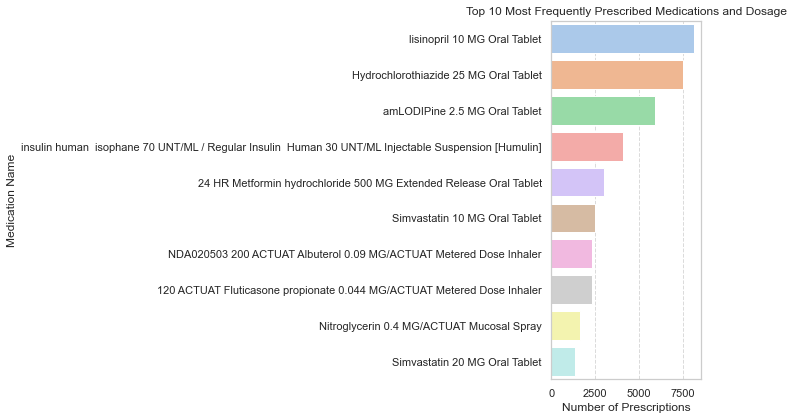

In [309]:
# Count the frequency of each medication
top_meds = medications['MEDICATION'].value_counts().nlargest(10)
sns.set_palette("pastel")

# Plot the top 10 medications
plt.figure(figsize=(10, 6))
sns.barplot(x=top_meds.values, y=top_meds.index)

plt.title('Top 10 Most Frequently Prescribed Medications and Dosage')
plt.xlabel('Number of Prescriptions')
plt.ylabel('Medication Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [310]:
medications.to_csv('medications_cleaned, index=False')

## As we can see Lisimopril is the most frequently prescribed, the patient population suffers from hypertension

-  for further cleaning I would group these medications, especially to create a baseline characteristics table

# Section 5: Encounters 

In [60]:
# Read medication dictionary CSV (columns: CODE, DESCRIPTION)
encounters = pd.read_csv(r"C:\Users\narin\Desktop\UCL_EMRs_Analysis\encounters.csv")
encounters.head(50)

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE
0,748f8357-6cc7-551d-f31a-32fa2cf84126,2019-02-17T05:07:38Z,2019-02-17T05:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,f7ae497d-8dc6-3721-9402-43b621a4e7d2,82608ebb-037c-3cef-9d34-3736d69b29e8,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,129.16,877.79,833.90,NaN
1,5a4735ae-423f-6563-28ab-b3d11b49b2d4,2019-03-24T05:07:38Z,2019-03-24T05:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,f7ae497d-8dc6-3721-9402-43b621a4e7d2,82608ebb-037c-3cef-9d34-3736d69b29e8,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,129.16,269.68,256.20,NaN
2,0bee1ce6-3e2c-5506-f71c-a7ba8f64a3d3,2019-05-26T05:07:38Z,2019-05-26T05:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,f7ae497d-8dc6-3721-9402-43b621a4e7d2,82608ebb-037c-3cef-9d34-3736d69b29e8,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,129.16,1292.75,1228.11,NaN
3,6e93bcf9-45a4-8528-0120-1c1eaa930faf,2019-07-28T05:07:38Z,2019-07-28T05:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,f7ae497d-8dc6-3721-9402-43b621a4e7d2,82608ebb-037c-3cef-9d34-3736d69b29e8,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,129.16,1323.87,1257.68,NaN
4,8b6787c3-4316-a0cb-899d-4746525c319f,2019-10-27T05:07:38Z,2019-10-27T05:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,f7ae497d-8dc6-3721-9402-43b621a4e7d2,82608ebb-037c-3cef-9d34-3736d69b29e8,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,129.16,831.76,790.17,NaN
5,8f424287-ee3a-c144-bc1d-3ba926e93fd5,2020-01-26T05:07:38Z,2020-01-26T05:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,f7ae497d-8dc6-3721-9402-43b621a4e7d2,82608ebb-037c-3cef-9d34-3736d69b29e8,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,129.16,129.16,122.70,NaN
6,fb15e123-fea7-cae8-6d49-ee9d2a85fc84,2020-02-05T06:07:38Z,2020-02-05T06:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,5103c940-0c08-392f-95cd-446e0cea042a,9f529022-166f-3db4-9f92-ff1ba11ee565,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,ambulatory,185347001,77.49,77.49,16.62,NaN
7,01efcc52-15d6-51e9-faa2-bee069fcbe44,2020-02-17T10:07:38Z,2020-02-17T10:40:32Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,5103c940-0c08-392f-95cd-446e0cea042a,9f529022-166f-3db4-9f92-ff1ba11ee565,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,ambulatory,185347001,77.49,594.14,507.43,NaN
8,1a7debfc-9582-7f23-a109-4f154a182ee2,2020-04-26T05:07:38Z,2020-04-26T05:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,f7ae497d-8dc6-3721-9402-43b621a4e7d2,82608ebb-037c-3cef-9d34-3736d69b29e8,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,129.16,1614.96,1534.21,NaN
9,bf38c711-941f-7509-f9ec-b864d6929f3f,2020-07-26T05:07:38Z,2020-07-26T05:22:38Z,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,f7ae497d-8dc6-3721-9402-43b621a4e7d2,82608ebb-037c-3cef-9d34-3736d69b29e8,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,129.16,269.68,256.20,NaN


In [57]:
encounters.shape

(61459, 13)

In [58]:
print(encounters.isnull().sum())

Id                         0
START                      0
STOP                       0
PATIENT                    0
ORGANIZATION               0
PROVIDER                   0
PAYER                      0
ENCOUNTERCLASS             0
CODE                       0
BASE_ENCOUNTER_COST        0
TOTAL_CLAIM_COST           0
PAYER_COVERAGE             0
REASONCODE             45502
dtype: int64


## Task 3b BMI measurements in patients with diagnosed hypertension. 

In [318]:
htn_df.head(1)

,LAB_DATE,Id,OBS_ENCOUNTER,CATEGORY,LOINC_CODE,VALUE,UNITS,TYPE,LOINC_DESCRIPTION,START,STOP,ENCOUNTER,CODE,DESCRIPTION,MARITAL,RACE,ETHNICITY,GENDER,AGE,HYPERTENSION_TYPE
0,2012-06-11 05:03:31+00:00,339144f8-50e1-633e-a013-f361391c4cff,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,vital-signs,8302-2,166.8,cm,numeric,Body Height,11/06/2012,17/06/2013,33782d5d-ba30-c2e5-c432-e36a8f6c1cc8,160968000,Risk activity involvement (finding),Unknown,white,nonhispanic,M,23,NaN


In [319]:
# Ensure date column is datetime
htn_df['LAB_DATE'] = pd.to_datetime(htn_df['LAB_DATE'])

# Sort by Id and LAB_DATE descending to get most recent diagnosis
htn_sorted = htn_df.sort_values(by=['Id', 'LAB_DATE'], ascending=[True, False])

# Keep latest hypertension record per patient
latest_htn = htn_sorted.drop_duplicates(subset='Id', keep='first')

In [320]:
# Filter for BMI entries
bmi_df = observations[observations['LOINC_CODE'] == '39156-5'].copy()

In [321]:
# Convert LAB_DATE to datetime
bmi_df['LAB_DATE'] = pd.to_datetime(bmi_df['LAB_DATE'])

# Sort so latest is first per patient
bmi_df = bmi_df.sort_values(by=['Id', 'LAB_DATE'], ascending=[True, False])

# Keep latest BMI per patient
latest_bmi = bmi_df.drop_duplicates(subset='Id', keep='first')

# Rename VALUE column to BMI for clarity
latest_bmi = latest_bmi.rename(columns={'VALUE': 'BMI'})


In [322]:
# UK BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight (<18.5)'
    elif 18.5 <= bmi < 25:
        return 'Healthy (18.5–24.9)'
    elif 25 <= bmi < 30:
        return 'Overweight (25–29.9)'
    elif 30 <= bmi < 40:
        return 'Obese (30–39.9)'
    else:
        return 'Severely Obese (≥40)'

# Apply categorisation
latest_bmi['BMI_Category'] = latest_bmi['BMI'].astype(float).apply(categorize_bmi)


In [323]:
# Merge BMI with hypertension records
bmi_htn = pd.merge(latest_bmi[['Id', 'BMI', 'BMI_Category']], latest_htn[['Id']], on='Id', how='inner')

In [324]:
# Merge latest BMI with HYPERTENSION_TYPE info
bmi_htn = pd.merge(
    latest_bmi[['Id', 'BMI', 'BMI_Category']],
    latest_htn[['Id', 'HYPERTENSION_TYPE']],
    on='Id',
    how='inner'
)


In [327]:
bmi_htn[['BMI_Category', 'HYPERTENSION_TYPE']].value_counts()

BMI_Category          HYPERTENSION_TYPE     
Overweight (25–29.9)  Malignant Hypertension    86
Obese (30–39.9)       Malignant Hypertension    22
Healthy (18.5–24.9)   Malignant Hypertension     4
dtype: int64

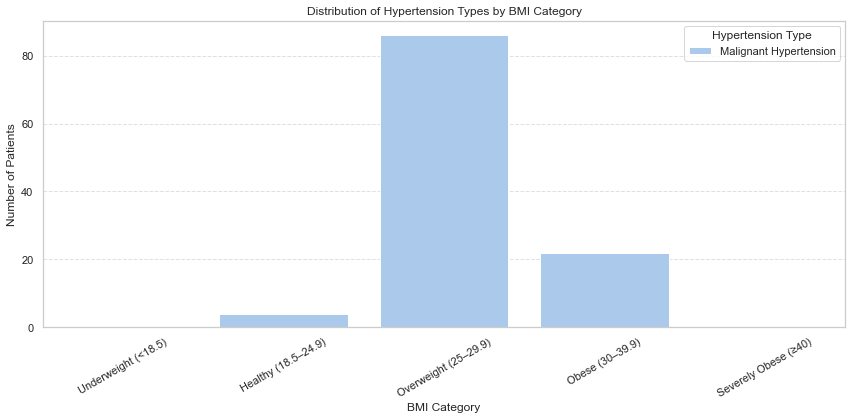

In [325]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count combinations
bmi_htn_counts = bmi_htn.groupby(['BMI_Category', 'HYPERTENSION_TYPE']).size().reset_index(name='Count')

bmi_order = [ 'Underweight (<18.5)', 'Healthy (18.5–24.9)',
    'Overweight (25–29.9)', 'Obese (30–39.9)', 'Severely Obese (≥40)'
]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=bmi_htn_counts,
    x='BMI_Category',
    y='Count',
    hue='HYPERTENSION_TYPE',
    order=bmi_order,
    palette='pastel'
)

plt.title('Distribution of Hypertension Types by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=30)
plt.legend(title='Hypertension Type')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

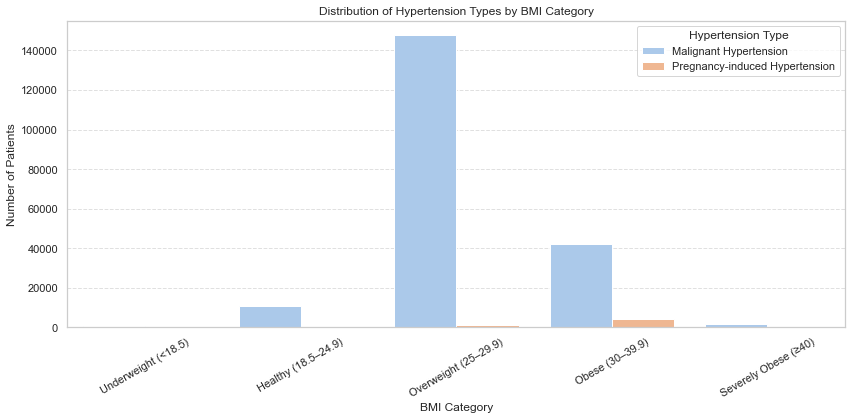

In [317]:
import seaborn as sns
import matplotlib.pyplot as plt

bmi_htn_counts = bmi_htn.groupby(['BMI_Category', 'HYPERTENSION_TYPE']).size().reset_index(name='Count')

bmi_order = [
    'Underweight (<18.5)', 'Healthy (18.5–24.9)',
    'Overweight (25–29.9)', 'Obese (30–39.9)', 'Severely Obese (≥40)'
]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=bmi_htn_counts,
    x='BMI_Category',
    y='Count',
    hue='HYPERTENSION_TYPE',
    order=bmi_order,
    palette='pastel'
)

plt.title('Distribution of Hypertension Types by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=30)
plt.legend(title='Hypertension Type')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# This shows the latest diagnosis of hypertension where majority patients are 'Overweight' according to the NICE guidelines BMI categories and for all hypertension records it is the same. 

# Task 4) CRUDE Prevalance and Adjusted

In [329]:
# Total patients
total_patients = patients['Id'].nunique()

# Patients with hypertension
htn_patients = htn_df['Id'].nunique()

# Crude prevalence
crude_prev = (htn_patients / total_patients) * 100
print(f"Crude Hypertension Prevalence: {crude_prev:.2f}%")


Crude Hypertension Prevalence: 98.59%


In [335]:
# Create a sample UK standard population table by age band and gender (based on ONS European Standard Population 2013)
uk_standard_population = pd.DataFrame({
    'Age_Band': ['<25', '25–34', '35–44', '45–54', '55–64', '65–74', '75–84', '85+'] * 2,
    'GENDER': ['M'] * 8 + ['F'] * 8,
    'Standard_Pop': [
        8000000, 9000000, 8500000, 8000000, 7000000, 6000000, 3000000, 1000000,  # Male
        7900000, 8800000, 8400000, 7900000, 6900000, 5800000, 3200000, 1200000   # Female
    ]
})

uk_standard_population.head(10) 

,Age_Band,GENDER,Standard_Pop
0,<25,M,8000000
1,25–34,M,9000000
2,35–44,M,8500000
3,45–54,M,8000000
4,55–64,M,7000000
5,65–74,M,6000000
6,75–84,M,3000000
7,85+,M,1000000
8,<25,F,7900000
9,25–34,F,8800000


In [331]:
def assign_age_band(age):
    if age < 25:
        return '<25'
    elif 25 <= age <= 34:
        return '25–34'
    elif 35 <= age <= 44:
        return '35–44'
    elif 45 <= age <= 54:
        return '45–54'
    elif 55 <= age <= 64:
        return '55–64'
    elif 65 <= age <= 74:
        return '65–74'
    elif 75 <= age <= 84:
        return '75–84'
    else:
        return '85+'

patients['Age_Band'] = patients['AGE'].apply(assign_age_band)


In [332]:
patients['Hypertension'] = patients['Id'].isin(hypertension_df['Id']).astype(int)


In [333]:
grouped = patients.groupby(['Age_Band', 'GENDER'])['Hypertension'].agg(['sum', 'count']).reset_index()
grouped.rename(columns={'sum': 'Cases', 'count': 'Population'}, inplace=True)
grouped['Rate'] = grouped['Cases'] / grouped['Population']


In [336]:
adjusted = pd.merge(grouped, uk_standard_population, on=['Age_Band', 'GENDER'], how='left')
adjusted['Weighted_Cases'] = adjusted['Rate'] * adjusted['Standard_Pop']

In [337]:
adjusted_prev = (adjusted['Weighted_Cases'].sum() / adjusted['Standard_Pop'].sum()) * 100
print(f"Age-Sex Adjusted Hypertension Prevalence: {adjusted_prev:.2f}%")


Age-Sex Adjusted Hypertension Prevalence: 27.79%


## Conclusion for Tasks 